# The Nuclear Electronic Orbital Method in a Quantum Computer Framework

## Quantum Computer Framework and Connection to Chemistry


Classical computers use a bit representation to encode information and instructions. Each of these bits encode 1 or 0 depending on whether they are on or off. Analogously, a quantum computer can encode information in terms of $|0\rangle$ and $|1\rangle$ states, but also allows entanglement between each of the states. This entanglement is beneficial to chemistry problems as electrons interact with other electrons and these interactions are often correlated and an important factor in molecular properties. While quantum chemistry frameworks exist to address the problem of electronic correlation, these methods are often computationally expensive due to poor scaling with system size. Thus, a quantum computer framework to solve chemical problems may allow more efficient calculations for properties of chemical interest and higher accuracy (due to the possibility of entanglement between different quantum computer states).

Thus, this tutorial will focus on

*   Solving an electronic structure in a classical computer, with a primer on Electronic Structure
*   Encoding a problem into a quantum computer form (3 steps)
**  Molecular Orbital Basis Transformation
**  Second Quantization
**  Qubit Encoding - Jordan-Wigner Map
*   Ansatz representation - Unitary Coupled Cluster with Singles, Doubles Excitations (UCCSD)

with each step exemplified by application to $H_2$. Finally the last section will also demonstrate an application to NEO-VQE.



## Library Installations

In [1]:
!pip install qiskit[all]
!pip install pyscf
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.7 MB 5.2 MB/s 
     |████████████████████████████████| 18.0 MB 257 kB/s 
     |████████████████████████████████| 240 kB 5.7 MB/s 
     |████████████████████████████████| 159 kB 46.6 MB/s 
     |████████████████████████████████| 50 kB 6.0 MB/s 
     |████████████████████████████████| 126 kB 57.8 MB/s 
     |████████████████████████████████| 2.0 MB 56.2 MB/s 
     |████████████████████████████████| 399 kB 58.6 MB/s 
     |████████████████████████████████| 162 kB 62.7 MB/s 
     |████████████████████████████████| 112 kB 38.0 MB/s 
     |████████████████████████████████| 55 kB 2.4 MB/s 
     |████████████████████████████████| 1.6 MB 51.0 MB/s 
     |████████████████████████████████| 49 kB 5.9 MB/s 
     |████████████████████████████████| 49 kB 4.9 MB/s 
     |████████████████████████████████| 943 kB 58.4 MB/s 
     |████████████████████████████████| 3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 38.2 MB 1.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 5.0 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.3
    Uninstalling matplotlib-3.5.3:
      Successfully uninstalled matplotlib-3.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
qiskit-experiments 0.4.0 requires matplotlib>=3.4, but you have matplotlib 3.1.3 which is incompatible.


## Primer on Electronic Structure

Electronic structure strives to obtain molecular properties based on a quantum mechanical description of chemical systems. Many methods exist with varying degree of accuracy and computational demands. This tutorial will describe the Hartree-Fock framework as the method to obtain an initial state and later the coupled cluster formalism to refine this initial state and obtain a more accurate electronic energy.

The electronic Hamiltonian is comprised of 1-electron kinetic energy, 2-electron repulsion, the nuclear-electronic potential term and the nuclear-nuclear potential, which is typically a constant under the Born-Oppenheimer approximation.

\begin{align}
	\hat{H} = h_{1e} + h_{2e} + h_{nuc}
\end{align}

Where, $h_{1e}$ contains the 1-electron terms, $h_{2e}$ contains the 2-electron terms and the $h_{nuc}$ contains the electron-proton attraction. Each of these terms require specification of a molecular structure and a basis set. In the next section, the procedure is shown to perform a calculation on a classical computer.


### Electronic Structure in a Classical Computer

This section exposes the methods containing the integrals within the PySCF electronic structure code. These are calculated for a given choice of molecular geometry, basis, charge and spin state. The following contains the same example of $H_2$ with a STO3-G basis, charge = 0 with both electrons paired. An Hartree-Fock electronic structure calculation example is also shown.

#### PySCF specific imports

These modules are required to generate a molecule object, `gto`, perform a self-consistent field calculation, `scf`, and convert integral matrices from an atomic orbital description to a molecular orbital description, `ao2mo`.

In [2]:
from pyscf import gto, scf
# from pyscf.scf import _vhf
from pyscf import ao2mo

In the application to the $H_2$ case, the following two lines use the method `M` of the class [`gto`](https://pyscf.org/user/gto.html) from PySCF, documented in ([gto](https://pyscf.org/pyscf_api_docs/pyscf.gto.html?highlight=pyscf+gto#module-pyscf.gto)) to define the molecule object. The molecular geometry is defined via `atom`, and the basis set with the `basis` keyword. By default, `charge=0` and `spin=0` implying a neutral species in the singlet state.

In [3]:
molecule = gto.M(atom='H 0 0 0; H 0 0 0.7414', basis='sto3g')

#### Integrals - AO basis

This section focuses on obtaining the integrals in an atomic orbital basis. The object instantiated from the class `gto` supports the method `intor` which allows access to the integrals is documented (https://pyscf.org/pyscf_api_docs/pyscf.gto.html?highlight=intor#pyscf.gto.mole.Mole.intor ) and allows specification of different types of integrals. In the following example we calculate each of these integrals, required by the Hartree-Hock method for the $H_2$ molecule as defined in the previous cell. Each integral equation is shown alongside the code element that calculates it.

The nuclear-electronic coulombic attraction integral for the electron is given by the expectation value of the operator:

\begin{equation}
	\hat{h}_{eN} = - \sum_{a}^{N_{nuclei}} \frac{Z_a}{|\vec{R}_a-\vec{r}|}
\end{equation}

And the expectation value itself:

\begin{equation}
	\langle \phi_i |\hat{h}_{eN} | \phi_j \rangle = - \langle \phi_i | \sum_{a}^{N_{nuclei}} \frac{Z_a}{|\vec{R}_a-\vec{r}|} | \phi_j \rangle = \int d\vec{x} \phi_i^*(\vec{x}) \left(\sum_{a}^{N_{nuclei}} \frac{Z_a}{|\vec{R}_a-\vec{r}|}\right)\phi_j(\vec{x})
\end{equation}

Where $Z_a$ is the nuclear charge, $R_a$ is the nuclear position and $r$ is the electron position

In [4]:
nuclear_1e = molecule.intor('int1e_nuc')
print("\n Nuclear-electronic coulombic attraction: \n", nuclear_1e)


 Nuclear-electronic coulombic attraction: 
 [[-1.88008303 -1.19385819]
 [-1.19385819 -1.88008303]]


The electronic kinetic energy integral for the electron is given by the expectation value of the operator:

\begin{equation}
	\hat{h}_{e,kin} = - \frac{1}{2} \nabla^2 
\end{equation}

And the expectation value itself:

\begin{equation}
	\langle \phi_i |\hat{h}_{e,kin} | \phi_j \rangle = - \langle \phi_i | \frac{1}{2} \nabla^2 | \phi_j \rangle = \int d\vec{x} \phi_i^*(\vec{x}) \left(-\frac{1}{2} \nabla^2 \right)\phi_j(\vec{x})
\end{equation}

In [5]:
kinetic_1e = molecule.intor('int1e_kin')
print("\n Electronic kinetic energy: \n", kinetic_1e)


 Electronic kinetic energy: 
 [[0.76003188 0.23612597]
 [0.23612597 0.76003188]]


The electronic kinetic energy integral for electron $i$ is given by the expectation value of the operator:

\begin{equation}
	\hat{h}_{ee} = \frac{1}{|{r}_1-{r}_2|}
\end{equation}

And the expectation value itself:

\begin{equation}
	\langle \phi_i \phi_j|\hat{h}_{ee} | \phi_k \phi_l \rangle = \langle \phi_i\phi_j | \frac{1}{|{r}_1-{r}_2|} | \phi_k \phi_l\rangle = \int d\vec{x}_1 \int d\vec{x}_2 \phi_i^*(\vec{x})\phi_j^*(\vec{x}) \left(\frac{1}{|{r}_1-{r}_2|} \right)\phi_k(\vec{x})\phi_l(\vec{x})
\end{equation}

This would yield a tensor containing all possible values for the indices $i$ and $j$, as indicated on the cell below.

In [6]:
coul_2e_full_ao = molecule.intor('int2e', aosym='s1')
import numpy as np
print("\n Electronic-electronic coulombic repulsion is a tensor of dimensions n^4 \n", np.shape(np.round(coul_2e_full_ao, decimals=6)))
print("\n Electronic-electronic coulombic repulsion, no-symmetry: \n", 
        coul_2e_full_ao)


 Electronic-electronic coulombic repulsion is a tensor of dimensions n^4 
 (2, 2, 2, 2)

 Electronic-electronic coulombic repulsion, no-symmetry: 
 [[[[0.77460594 0.44379315]
   [0.44379315 0.56946841]]

  [[0.44379315 0.29666317]
   [0.29666317 0.44379315]]]


 [[[0.44379315 0.29666317]
   [0.29666317 0.44379315]]

  [[0.56946841 0.44379315]
   [0.44379315 0.77460594]]]]


In practice, symmetry can be exploited such that few integrals are calculated, allowing for time/memory savings.

In [7]:
coul_2e_sym_ao = molecule.intor('int2e', aosym='s8')
print("\n Electronic-electronic coulombic repulsion: \n", coul_2e_sym_ao)


 Electronic-electronic coulombic repulsion: 
 [0.77460594 0.44379315 0.29666317 0.56946841 0.44379315 0.77460594]


The nuclear-nuclear integral is given by the expression.

\begin{equation}
	\hat{h}_{eN} = \sum_{a}^{N_{nuclei}}\sum_{b > a}^{N_{nuclei}} \frac{Z_a Z_b}{|{R}_a-{R}_b|}
\end{equation}

In the Born-Oppenheimer approximation, the nuclei are static with respect to the fast-moving electrons and thus this term is typically a constant added to the electronic energy.

In [8]:
nuclear_rep = molecule.get_enuc()
print("\n Nuclear-nuclear coulombic repulsion", nuclear_rep)


 Nuclear-nuclear coulombic repulsion 0.7137539936876182


The so-called core hamiltonian is comprised of one-electron terms, that is:

\begin{equation}
	\hat{h}_{core} = \hat{h}_{e,kin} + \hat{h}_{eN}
\end{equation}

In [9]:
hcore_ao = molecule.get_hcore()
print("\n Core hamiltonian, sum of 1 electron terms \n", hcore_ao)

converged SCF energy = -1.11668438708534

 Core hamiltonian, sum of 1 electron terms 
 [[-1.12005114 -0.95773222]
 [-0.95773222 -1.12005114]]


### The Electronic Structure Problem
Solving the Hartree-Fock electronic structure problem using the PySCF package and collecting electronic energy, molecular orbital coefficients and molecular orbital energies. The RHF method is being used from the self-consistent field module, using the previously defined molecule object as argument.

In [10]:
# Electronic structure calculation
RHF_calc = scf.RHF(molecule)

This cell runs the calculation and **updates** the atributes of the `RHF_calc` object. All the electronic structure observables supported by PySCF populate the associated attributes.

In [11]:
scf_result = RHF_calc.kernel()

converged SCF energy = -1.11668438708534


Calling the `scf_result` after the calculation execution yields only the electronic energy, given by the following expression:

\begin{equation}
    E = \sum_{i}^{N_elec} \langle \phi_i|\hat{h}_i| \phi_i\rangle + \frac{1}{2} \sum_{ij}^{N_{elec}} (\langle \phi_i \phi_j|\hat{h}_{ee}| \phi_i \phi_j \rangle - \langle \phi_i \phi_j|\hat{h}_{ee}| \phi_j \phi_i \rangle) + V_{NN}
\end{equation}

In [12]:
print("\n Reference Electronic Energy: \n", scf_result)


 Reference Electronic Energy: 
 -1.1166843870853405


However, other attributes can be accessed, including the molecular orbital expansion in the atomic orbital basis, via `mo_coeff`, as well as the molecular orbital energies, via `mo_en`. Do note that `mo_coeff` is a matrix of size $n$ by $n$, where $n$ is the number of basis functions, with each column being a different molecular orbital and each row an atomic orbital.

In [13]:
# MO coefficients and energies
mo_coeff = RHF_calc.mo_coeff
mo_en = RHF_calc.mo_energy
print("\n Molecular Orbital coefficients in AO basis: \n", mo_coeff)
print("\n Molecular Orbital Energies: \n", mo_en)


 Molecular Orbital coefficients in AO basis: 
 [[ 0.54899378  1.21082257]
 [ 0.54899378 -1.21082257]]

 Molecular Orbital Energies: 
 [-0.57797481  0.66969867]


Solving the Hartree-Fock generalized eigenvalue problem manually, from the Fock matrix and the overlap matrix, requires solving the generalized eigenvalue problem:

\begin{equation}
    FC = SCE
\end{equation}

Where $F$ is the Fock matrix, $S$ is the overlap matrix, $C$ is the molecular orbital coefficient matrix and $E$ is the energy vector. The Fock matrix is defined:

\begin{equation}
    F = h + G\cdot D 
\end{equation}

Where $h$ is the one-electron matrix, $D$ is the density matrix and $G$ is the 4 dimensional tensor containing the two electron integrals The calculation proceeds iteratively until finding the optimal density that minimizes the Hartree-Fock energy.

The Fock and overlap matrices can be obtained by accessing the the `get_fock` and `get_ovlp` methods from the `RHF_calc` object.

In [14]:
# Relevant matrices for generalized eigenvalue equation FC = SCE
fock = RHF_calc.get_fock()
ovlp = RHF_calc.get_ovlp()
print("\n Fock matrix: \n", fock)
print("\n Overlap matrix: \n", ovlp)


 Fock matrix: 
 [[-0.36521973 -0.59361569]
 [-0.59361569 -0.36521973]]

 Overlap matrix: 
 [[1.         0.65895712]
 [0.65895712 1.        ]]


Solving the generalized eigenvalue problem requires recasting the above equation:

\begin{align}
    FC = SCE \equiv S^{-1}FC = CE
\end{align}

The following function harnesses the `numpy` library to perform matrix algebra and order the eigenvalues and corresponding eigenvectors for a given matrix, `A`.

In [15]:
import numpy as np

def eigen(A):
    '''
        Given a matrix A, returns ordered eigenvalues and corresponding eigenvectors
        Eigenvectors are in column format
    '''
    eigenValues, eigenVectors = np.linalg.eig(A)
    idx = np.argsort(eigenValues)[::]
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return (eigenValues, eigenVectors)

By calling the `eigen` function on the product $S^{-1}F$, the molecular orbital energies `E` and molecular orbital coefficient expansion `C`.

In [16]:
geneigen_mo_en, geneigen_mo_coeff = eigen(np.linalg.inv(ovlp) @ fock)
print("Based on the generalized eigenvalue problem approach, ")
print("\n Molecular Orbital coefficients in AO basis: \n", geneigen_mo_coeff)
print("\n Molecular Orbital Energies: \n", geneigen_mo_en)

Based on the generalized eigenvalue problem approach, 

 Molecular Orbital coefficients in AO basis: 
 [[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]

 Molecular Orbital Energies: 
 [-0.57797481  0.66969867]


## Encoding

* Obtain integrals and transform to MO basis
* Second quantization
* Qubit mapping

### Integrals MO Basis

While the above integrals are expressed in the basis of atomic orbitals, they can also be cast into the molecular orbital basis, by virtue of the molecular orbital expansion matrix in the basis of atomic orbitals. This section expresses how this change of basis can be accomplished for the case of two spatial basis functions as in the hydrogen molecule.

For the molecular orbitals expressed in terms of atomic orbitals as follows:

\begin{gather*}
| \Phi _1 \rangle = c_{11} | \phi _1 \rangle + c_{12} | \phi _2 \rangle \\
| \Phi _2 \rangle = c_{21} | \phi _1 \rangle + c_{22} | \phi _2 \rangle
\end{gather*}

Similarly,

\begin{gather*}
\langle \Phi _1 | = c_{11} \langle \phi _1 | + c_{12} \langle \phi _2 | \\
\langle \Phi _2 | = c_{21} \langle \phi _1 | + c_{22} \langle \phi _2 |
\end{gather*}

We can express some expectation value of the operator as follows:

\begin{gather*}
    \langle \Phi_1 | \hat{O} | \Phi _1 \rangle \\
    \langle \Phi_2 | \hat{O} | \Phi _2 \rangle
\end{gather*}

Using the prior equations and substituting we obtain: 

\begin{gather*}
    \langle \Phi_1 | \hat{O} | \Phi _1 \rangle = 
    (c_{11} \langle \phi _1 | + c_{12} \langle \phi _2 |)
    \hat{O} (c_{11} | \phi _1 \rangle + c_{12} | \phi _2 \rangle) \\
    = c_{11} c_{11} \langle \phi _1 | \hat{O} | \phi _1 \rangle + (c_{11} c_{12} \langle \phi _1 | \hat{O} | \phi _2 \rangle \\
    + c_{12} c_{11} \langle \phi _2 | \hat{O} | \phi _1 \rangle + c_{12} c_{12} \langle \phi _2 | \hat{O} | \phi _2 \rangle \\
    \langle \Phi_2 | \hat{O} | \Phi _2 \rangle = 
    (c_{21} \langle \phi _1 | + c_{22} \langle \phi _2 |)
    \hat{O} (c_{21} | \phi _1 \rangle + c_{22} | \phi _2 \rangle) \\
    = c_{21} c_{21} \langle \phi _1 | \hat{O} | \phi _1 \rangle + (c_{21} c_{22} \langle \phi _1 | \hat{O} | \phi _2 \rangle \\
    + c_{22} c_{21} \langle \phi _2 | \hat{O} | \phi _1 \rangle + c_{22} c_{22} \langle \phi _2 | \hat{O} | \phi _2 \rangle
\end{gather*}

For the 1-electron components, note that the PySCF documentation uses the following procedure internally:

In [17]:
hcore_mo = np.einsum('pi,pq,qj->ij', mo_coeff, hcore_ao, mo_coeff)
print(np.round(hcore_mo,decimals=6))

[[-1.252464  0.      ]
 [-0.       -0.475949]]


In practice, what this means is that for an matrix containing molecular orbitals written as linear combination of atomic orbitals, with each column representing an MO and rows representing different AOs:

\begin{equation}
C_{MO} = 
\left[\begin{array}{c|cc}
& MO_1 & MO_2 \\
\hline
AO_1 & & \\
AO_2 & & \\
\end{array}\right]
\end{equation}

multiplying from the left with the transpose of this matrix by the 1-electron-integral matrix and by the right with the matrix yields the 1-electron-integral matrix in molecular orbital basis:

\begin{equation}
C_{MO}^T H^{1e^-}_{AO} C_{MO} = H^{1e^-}_{MO}
\end{equation}

Which is the same matrix we obtained above:

In [18]:
hcore_mo_manual = mo_coeff.T @ hcore_ao @ mo_coeff
print(np.round(hcore_mo_manual, decimals=6))

[[-1.252464  0.      ]
 [-0.       -0.475949]]


Furthermore, the ao2mo pyscf module allows conversion of these 2-electron integrals from the AO basis to the MO basis, provided with the coefficients of the MOs in terms of the AO basis.

In [19]:
coul_2e_full_mo = ao2mo.incore.full(coul_2e_full_ao, mo_coeff)
print('Tensor of dimensions n^4', np.shape(np.round(coul_2e_full_mo, decimals=6)))
print(np.round(coul_2e_full_mo, decimals=6))

Tensor of dimensions n^4 (2, 2, 2, 2)
[[[[ 0.674489 -0.      ]
   [-0.        0.663468]]

  [[ 0.        0.181289]
   [ 0.181289  0.      ]]]


 [[[ 0.        0.181289]
   [ 0.181289  0.      ]]

  [[ 0.663468  0.      ]
   [ 0.        0.697394]]]]


These values are identical as those listed in this [journal article](https://arxiv.org/pdf/1208.5986.pdf) describing this calculation for $H_2$.

In [20]:
print(np.round(hcore_mo[0][0],decimals=6))
print(np.round(hcore_mo[1][1],decimals=6))
print(np.round(coul_2e_full_mo[0][0][0][0],decimals=6))
print(np.round(coul_2e_full_mo[1][1][1][1],decimals=6))
print(np.round(coul_2e_full_mo[0][0][1][1],decimals=6))
print(np.round(coul_2e_full_mo[1][0][0][1],decimals=6))

-1.252464
-0.475949
0.674489
0.697394
0.663468
0.181289


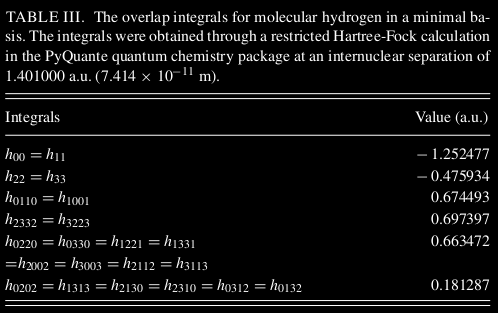

### Second Quantization

Now that the integrals are obtained, an intermediate step for the representation in a qubit basis is necessary. This is the transformation into a second quantized formalism, which expresses each of the integral elements, with respect to the occupation of each of the states. This encoding in terms of the occupation of states can then be readily translated to a qubit basis (which supports either a $|0\rangle$ or $|1\rangle$ representation) For example, a $H_2$ molecule in a minimal basis would have 4 spin molecular orbitals ($\sigma$ bonding, and $\sigma^*$ antibonding):

\begin{equation}
	\sigma_{\alpha}, \;
	\sigma_{\beta}, \;
	\sigma_{\alpha}^*, \;
	\sigma_{\beta}^*
\end{equation}

Second quantization allows the basis of states for the system to be populated with particles, by acting with raising (creation) $a^\dagger$ and or removing them with lowering (anhihilation) operators $a$. Thus, for the $H_2$ minimal basis example, defining the system as the product of states without electrons:

\begin{equation}
	|\sigma_{\alpha}^{(0)}, \;
	\sigma_{\beta}^{(0)}, \;
	\sigma_{\alpha}^{*(0)}, \;
	\sigma_{\beta}^{*(0)} \rangle
\end{equation}

We can define the ground state by creating electrons on the $\alpha$ and $\beta$ bonding orbitals ($\sigma$)
\begin{equation}
	a^{\dagger}_{\sigma_{\alpha}}a^{\dagger}_{\sigma_{\beta}}
	|\sigma_{\alpha}^{(0)}, \;
	\sigma_{\beta}^{(0)}, \;
	\sigma_{\alpha}^{*(0)}, \;
	\sigma_{\beta}^{*(0)} \rangle = |\sigma_{\alpha}^{(1)}, \;
	\sigma_{\beta}^{(1)}, \;
	\sigma_{\alpha}^{*(0)}, \;
	\sigma_{\beta}^{*(0)} \rangle
\end{equation}

Furthermore, all the integrals can be expressed in terms of this occupation basis. Thus, in second quantization the 1-electron and 2-electron integral elements of the Hamiltonian can be expressed as follows: 

\begin{gather}
	h_{1e} = \sum_{p,q} h_q^p \hat{a}_p^{\dagger} \hat{a}_q\\
	h_{2e} = \dfrac{1}{2} \sum_{p,q,r,s} h_{rs}^{pq}
		\hat{a}_p^{\dagger} \hat{a}_q^{\dagger} \hat{a}_r \hat{a}_s \\
	\Rightarrow
		\hat{H} = \sum_{p,q} h_q^p \hat{a}_p^{\dagger} \hat{a}_q
			+ \dfrac{1}{2} \sum_{p,q,r,s} h_{rs}^{pq} \hat{a}_p^{\dagger} \hat{a}_q^{\dagger} \hat{a}_r \hat{a}_s 
			+ E_{NN}
\end{gather}

where $h_q^p$, $h_{rs}^{pq}$, $h_{nuc}$ are 1-electron (including kinetic and electron-nuclei coulombic terms), 2-electron integrals and nuclear-nuclear electrostatic potential respectively, as defined above. Note that the sum is taken over all spin orbitals N for some finite number of N.
The resulting values for the each of the individual operators constituting the Hamiltonian are calculated in the exact same manner for either first or second quantization. To accomplish the second quantization transformation, we utilize the functions in the qiskit library to create custom integral objects and then perform the transformation on this object.

These imports allow the creation of `qiskit` compatible integral objects (`OneBodyElectronicIntegrals`, `TwoBodyElectronicIntegrals`) to which we can feed the integrals calculated above with PySCF in the appropriate basis (by virtue of `ElectronicBasis`). This section leverages the property objects as documented in [`qiskit_nature chemistry tutorial #8`](https://github.com/Qiskit/qiskit-nature/blob/96d0e3b2336ed2ece291abc94a2d91d1dc6c4edb/docs/tutorials/08_property_framework.ipynb). Note that chemistry tutorial #8 is available prior to commit #792 as Qiskit is being refactored (['Towards a non-driver future #796'](https://github.com/Qiskit/qiskit-nature/pull/796))

In [21]:
from qiskit_nature.properties.second_quantization.electronic.integrals import (
    OneBodyElectronicIntegrals,
    TwoBodyElectronicIntegrals
)

from qiskit_nature.properties.second_quantization.electronic.bases import ElectronicBasis

For modularity, these qiskit library calls have been wrapped in suitable functions thate take 1 and 2-electron integrals as input and output the corrsponding qiskit integral objects in the appropriate basis. Note that `OneBodyElectronicIntegrals` takes the basis object definition, `ElectronicBasis.AO` for example, and a tuple as arguments. The tuple encodes the $\alpha$ and $\beta$ integrals, which in this case are the same due to degeneracy of the orbitals in a restricted Hartree-Fock calculation. Thus, by specifying the second entry of the tuple to be `None`, ie `OneBodyElectronicIntegrals(        ElectronicBasis.AO, (ints_1e_ao,None))` the $\beta$ orbital integrals will have the same values as the $\alpha$. This also applies to the `TwoBodyElectronicIntegrals` object.

In [22]:
def getIntegrals_object_ao_basis_qiskit(ints_1e_ao, ints_2e_ao):
    one_body_ints_ao = OneBodyElectronicIntegrals(
        ElectronicBasis.AO, (ints_1e_ao,None))
    two_body_ints_ao = TwoBodyElectronicIntegrals(
        ElectronicBasis.AO, (ints_2e_ao, None, None, None))
    return one_body_ints_ao, two_body_ints_ao

def getIntegrals_object_mo_basis_qiskit(ints_1e_mo, ints_2e_mo):
    one_body_ints_mo = OneBodyElectronicIntegrals(
        ElectronicBasis.MO, (ints_1e_mo,None))
    two_body_ints_mo = TwoBodyElectronicIntegrals(
        ElectronicBasis.MO, (ints_2e_mo, None, None, None))
    return one_body_ints_mo, two_body_ints_mo

Calling the functions using the integrals obtained with PySCF as arguments:

In [23]:
ao_1e_int_obj, ao_2e_int_obj = getIntegrals_object_ao_basis_qiskit(hcore_ao, coul_2e_full_ao)
print('1-electron integral object in AO basis: \n', ao_1e_int_obj)
print('2-electron integral object in AO basis: \n', ao_2e_int_obj)

1-electron integral object in AO basis: 
 (AO) 1-Body Terms:
	Alpha
	<(2, 2) matrix with 4 non-zero entries>
	[0, 0] = -1.1200511418451156
	[0, 1] = -0.9577322214043147
	[1, 0] = -0.9577322214043147
	[1, 1] = -1.1200511418451156
	Beta
	Same values as the corresponding primary-spin data.
2-electron integral object in AO basis: 
 (AO) 2-Body Terms:
	Alpha-Alpha
	<(2, 2, 2, 2) matrix with 16 non-zero entries>
	[0, 0, 0, 0] = 0.7746059439198978
	[0, 0, 0, 1] = 0.44379315355964943
	[0, 0, 1, 0] = 0.4437931535596493
	[0, 0, 1, 1] = 0.5694684067537881
	[0, 1, 0, 0] = 0.4437931535596493
	... skipping 11 entries
	Beta-Alpha
	Same values as the corresponding primary-spin data.
	Beta-Beta
	Same values as the corresponding primary-spin data.
	Alpha-Beta
	Same values as the corresponding primary-spin data.


In [24]:
mo_1e_int_obj, mo_2e_int_obj = getIntegrals_object_mo_basis_qiskit(hcore_mo, coul_2e_full_mo)
print('1-electron integral object in MO basis: \n', mo_1e_int_obj)
print('2-electron integral object in MO basis: \n', mo_2e_int_obj)

1-electron integral object in MO basis: 
 (MO) 1-Body Terms:
	Alpha
	<(2, 2) matrix with 2 non-zero entries>
	[0, 0] = -1.2524635735648983
	[1, 1] = -0.47594871522096427
	Beta
	Same values as the corresponding primary-spin data.
2-electron integral object in MO basis: 
 (MO) 2-Body Terms:
	Alpha-Alpha
	<(2, 2, 2, 2) matrix with 8 non-zero entries>
	[0, 0, 0, 0] = 0.6744887663568375
	[0, 0, 1, 1] = 0.6634680964235682
	[0, 1, 0, 1] = 0.18128880821149596
	[0, 1, 1, 0] = 0.181288808211496
	[1, 0, 0, 1] = 0.1812888082114958
	... skipping 3 entries
	Beta-Alpha
	Same values as the corresponding primary-spin data.
	Beta-Beta
	Same values as the corresponding primary-spin data.
	Alpha-Beta
	Same values as the corresponding primary-spin data.


These integral objects can be further nested into an `ElectronicEnergy` object, to allow further manipulations such as second quantization and eventually qubit mapping.

In [25]:
from qiskit_nature.properties.second_quantization.electronic import (
    ElectronicEnergy)

As arguments, `ElectronicEnergy` should be provided with the qiskit integral objects in both AO and MO basis, the nuclear repulsion and optionally the electronic energy value obtained in a classical computer.

In [26]:
def getElectronicEnergy_object(
    ao_1e_int_obj, ao_2e_int_obj, mo_1e_int_obj, mo_2e_int_obj,
    nuclear_rep, scf_result):
    
    electronic_energy_from_ints = ElectronicEnergy(
        [ao_1e_int_obj, ao_2e_int_obj, mo_1e_int_obj, mo_2e_int_obj],
        nuclear_rep,
        scf_result)
    return electronic_energy_from_ints

electronic_energy_from_ints = getElectronicEnergy_object(
    ao_1e_int_obj, ao_2e_int_obj, mo_1e_int_obj, mo_2e_int_obj, nuclear_rep, scf_result)

Now we are ready to call the `second_q_ops()` method of the `ElectronicEnergy` object and perform the conversion from first to second quantization.

In [27]:
second_quant_ham = electronic_energy_from_ints.second_q_ops()[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ListAuxOpsDeprecationWarning: List-based `aux_operators` are deprecated as of version 0.3.0 and support for them will be removed no sooner than 3 months after the release. Instead, use dict-based `aux_operators`. You can switch to the dict-based interface immediately, by setting `qiskit_nature.settings.dict_aux_operators` to `True`.
  """Entry point for launching an IPython kernel.


We can also make a list (via the `.to_list()` method) from this method returned value to examine the form of the operators:

In [28]:
second_quant_ham_list = second_quant_ham.to_list()

for idx,entry in enumerate(second_quant_ham_list):
    print("2nd Quantized operator {0} = {1}, {2}".format(idx, entry[1], entry[0]))

2nd Quantized operator 0 = -1.2524635735648983, +_0 -_0
2nd Quantized operator 1 = -0.47594871522096427, +_1 -_1
2nd Quantized operator 2 = -1.2524635735648983, +_2 -_2
2nd Quantized operator 3 = -0.47594871522096427, +_3 -_3
2nd Quantized operator 4 = -0.33724438317841876, +_0 +_0 -_0 -_0
2nd Quantized operator 5 = -0.09064440410574802, +_0 +_1 -_1 -_0
2nd Quantized operator 6 = -0.090644404105748, +_0 +_0 -_1 -_1
2nd Quantized operator 7 = -0.331734048211784, +_0 +_1 -_0 -_1
2nd Quantized operator 8 = -0.33724438317841876, +_0 +_2 -_0 -_2
2nd Quantized operator 9 = -0.09064440410574802, +_0 +_3 -_1 -_2
2nd Quantized operator 10 = -0.090644404105748, +_0 +_2 -_1 -_3
2nd Quantized operator 11 = -0.331734048211784, +_0 +_3 -_0 -_3
2nd Quantized operator 12 = -0.3317340482117841, +_1 +_0 -_1 -_0
2nd Quantized operator 13 = -0.0906444041057479, +_1 +_1 -_0 -_0
2nd Quantized operator 14 = -0.09064440410574798, +_1 +_0 -_0 -_1
2nd Quantized operator 15 = -0.34869688371151364, +_1 +_1 -_1 -_

### Qubit Mapping

### Jordan-Wigner Transformation Example

The Jordan-Wigner transformation allows a map to be made between fermionic, second quantized,  operators into qubit operators. A creation operator $ a^{\dagger}_i $ acting on a vaccum state (ie $a^{\dagger}_i | vacuum \rangle$) generates a fermion in level $i$. Populating the system with n-levels with n fermions requires n applications of the creation operator, ie

\begin{align*} 
\left( \prod _{i=1} ^n a^{\dagger}_i \right) | vacuum \rangle 
\end{align*}

Note that creating a fermion in level $i+1$ before creating one in level $i$ changes the sign of the of the operations, according to the anti-commutation rules expressed above, as follows:

\begin{align*}
a^{\dagger}_i a^{\dagger}_{i+1} | vacuum \rangle = 
- a^{\dagger}_{i+1} a^{\dagger}_{i} | vacuum \rangle 
\end{align*}

Thus mapping a creation operator into a string of Pauli matrices (used as basis in quantum computer), per the Jordan-Wigner transformation, includes the sign as a Kronecker product of Pauli z-matrices, $ \sigma _z$, up to the level $i$ where a fermion is created, a $ \sigma _+$ on level $i$ and identity matrices on all states greater than $i$. Similarly a anhihilation operator can be produced by an identical transformation, but replacing the $ \sigma _+$ on level $i$ by a $ \sigma _-$ on level $i$. In summary for a creation operator on site $i$ in a $n$-level system:

\begin{align*}
a^{\dagger}_i = \left( \bigotimes _{k=1} ^{i-1} \sigma _z \right)
\otimes \sigma _+ ^{i} \otimes \left( \bigotimes _{k=i+1} ^{n} \mathbb{I} \right)
\end{align*}

While for a anhihilation operator,

\begin{align*}
a _i = \left( \bigotimes _{k=1} ^{i-1} \sigma _z \right)
\otimes \sigma _- ^{i} \otimes \left( \bigotimes _{k=i+1} ^{n} \mathbb{I} \right)
\end{align*}

For a 3-level system, a creation operator acting on site 2 would be expressed as follows:

\begin{align*}
a^{\dagger}_2 =  \sigma _z \otimes \sigma _+ ^{2} \otimes \mathbb{I}
\end{align*}

Where $\otimes$ is the Kronecker product (outer-product). Expressing the above more explicitly, 

\begin{align*}
a^{\dagger}_2 =  \begin {bmatrix} 1 & 0 \\ 0 & -1 \end {bmatrix} 
\otimes \begin {bmatrix} 0 & 1 \\ 0 & 0 \end {bmatrix} 
\otimes \begin {bmatrix} 1 & 0 \\ 0 & 1 \end {bmatrix}
= 
\begin {bmatrix} 
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & -1 \\
0 & 0 & 0 & 0 \\
\end {bmatrix} 
\otimes \begin {bmatrix} 1 & 0 \\ 0 & 1 \end {bmatrix}
=
\begin {bmatrix} 
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & -1 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
\end {bmatrix} 
\end{align*}

See the following for more details on the [Jordan-Wigner (JW) mapping](https://arxiv.org/pdf/0705.1928.pdf): 
and the following for more details on the JW and other mappings:
https://math.berkeley.edu/~linlin/2018Spring_290/SRL12.pdf

A single particle Hamiltonian can be expressed as follows:

\begin{align*}
h^{(1)} = \sum _i h_{ii} a^{\dagger}_i a_i + \sum _{i<j} h_{ij} (a^{\dagger}_i a_j + a^{\dagger}_j a_i)
\end{align*}

Based on the above expressions, 

\begin{align*}
a^{\dagger}_i a_i =
\left[ \left( \bigotimes _{k=1} ^{i-1} \sigma _z \right)
\otimes \sigma _+ ^{i} \otimes \left( \bigotimes _{k=i+1} ^{n} \mathbb{I} \right) \right]
\left[ \left( \bigotimes _{k=1} ^{i-1} \sigma _z \right)
\otimes \sigma _- ^{i} \otimes \left( \bigotimes _{k=i+1} ^{n} \mathbb{I} \right) \right]
\end{align*}

Simplification requires the use of the distributive properties of the Kronecker product:

\begin{align*}
(A \otimes B )(C \otimes D) = (AC) \otimes (BD)
\end{align*}

Thus,

\begin{align*}
a^{\dagger}_i a_i =
\left[ \left( \bigotimes _{k=1} ^{i-1} \sigma _z^2 \right)
\otimes (\sigma _+ ^{i} \sigma _- ^{i}) \otimes \left( \bigotimes _{k=i+1} ^{n} \mathbb{I} ^2 \right) \right]
=
\left[ \left( \bigotimes _{k=1} ^{i-1} \mathbb{I} \right)
\otimes (\sigma _+ ^{i} \sigma _- ^{i}) \otimes \left( \bigotimes _{k=i+1} ^{n} \mathbb{I} \right) \right]
\end{align*}

Note that
\begin{align*}
\sigma _+ \sigma _- = \dfrac{(\sigma _z + \mathbb{I})}{2}
\end{align*}
\begin{align*}
\Rightarrow 
a^{\dagger}_i a_i = \left[ \left( \bigotimes _{k=1} ^{i-1} \mathbb{I} \right)
\otimes \dfrac{(\sigma _z + \mathbb{I})}{2} \otimes \left( \bigotimes _{k=i+1} ^{n} \mathbb{I} \right) \right]
\end{align*}

Additionally, $ \sigma _+ \sigma _- $ is called the number operator as it can count whether a fermion is in a particular state of the system. To see why this is the case, for a single state system:

$
\sigma _+ \sigma _- = \begin{bmatrix} 1 & 0 \\ 0 & 0\end{bmatrix} $ \\

$(\sigma _+ \sigma _-) | 0 \rangle = 1 | 0 \rangle $ \\
$(\sigma _+ \sigma _-) | 1 \rangle = 0 | 1 \rangle$

Other representations for operators can be derived in a similar fashion.

Harnessing the `QubitConverter` of qiskit alongside with the choice of qubit mapper (exemplified by `JordanWignerMapper`) allows encoding of the `ElectronicEnergy` object defined above to be mapped into a qubit basis.

In [29]:
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper

First, we instantiate a `QubitConverter` with the mapper of choice:

In [30]:
jw_qubit_op_ham = QubitConverter(mapper=JordanWignerMapper())

Then we call the `.convert()` method of this object, using the `ElectronicEnergy` object defined above:

In [31]:
qubit_op = jw_qubit_op_ham.convert(second_quant_ham)

 to obtain the qubit basis operators

In [32]:
for idx,entry in enumerate(qubit_op):
    print("Jordan Wigner term operator {0}:  {1}".format(idx, entry))

Jordan Wigner term operator 0:  -0.8126179630230765 * IIII
Jordan Wigner term operator 1:  0.17119774903432977 * IIIZ
Jordan Wigner term operator 2:  -0.22278593040418476 * IIZI
Jordan Wigner term operator 3:  0.17119774903432977 * IZII
Jordan Wigner term operator 4:  -0.2227859304041847 * ZIII
Jordan Wigner term operator 5:  0.12054482205301802 * IIZZ
Jordan Wigner term operator 6:  0.16862219158920938 * IZIZ
Jordan Wigner term operator 7:  (0.04532220205287399-2.6675435322267557e-16j) * YYYY
Jordan Wigner term operator 8:  0.04532220205287399 * XXYY
Jordan Wigner term operator 9:  0.04532220205287399 * YYXX
Jordan Wigner term operator 10:  0.04532220205287399 * XXXX
Jordan Wigner term operator 11:  0.16586702410589202 * ZIIZ
Jordan Wigner term operator 12:  0.16586702410589202 * IZZI
Jordan Wigner term operator 13:  0.17434844185575682 * ZIZI
Jordan Wigner term operator 14:  0.12054482205301802 * ZZII


## Ansatz representation - UCCSD

Coupled cluster methods account for singles, doubles, triples, ..., excitations as a way to incorporate electronic correlation within a ground state reference (typically a Hartree-Fock reference). All corrections of a given type are included. Defining an excitation operator as follows:

\begin{align*}
    {T} = {T}_1 + {T}_2 + {T}_3 + \ldots + {T}_{N_{elec}}
\end{align*}

A $T_i$ operator acting on a reference Hartree-Fock ansatz, $\Phi _0$, generates all $i$th excited Slater determinants, as follows:

\begin{align*}
    {T}_1 \Phi _0 = \sum_{i}^{occ} \sum_{a}^{vir} t_i^a \Phi _i^a
    \\
    {T}_2 \Phi _0 = \sum_{i < j}^{occ} \sum_{a < b}^{vir} t_{ij}^{ab} \Phi _{ij}^{ab}
    \\ \ldots
\end{align*}

Where each coefficient t is typically designated as an amplitude. The coupled cluster (CC) wavefunction is typically given by the expression:

\begin{align*}
    \Psi_{CC} = e^{{T}} \Phi _0
\end{align*}

The exponential operator can be Taylor expanded as follows:

\begin{align*}
    e^{{T}} = {1} + {T} + \dfrac{1}{2} {T}^2 + \dfrac{1}{6} {T}^3 + \ldots 
                = \sum_{k=0}^{\infty} \dfrac{1}{k!} {T}^k
\end{align*}

Using the form of the excitation operator along with the Taylor expanded CC-operator and collecting "like" terms designating each type of excitation (singles, doubles, triples, etc):

\begin{align*}
    e^{{T}}  = {1} + {T}_1
                + ({T}_2 + \dfrac{1}{2} {T}_1^2)
                + ({T}_3 + {T}_2 {T}_1 + \dfrac{1}{6} {T}_1^3)
                + \ldots 
\end{align*}

In practice the expansion is typically truncated to some finite order (ie singles, doubles). The coupled cluster wavefunction is then given by 

\begin{align*}
    \hat{H}\ e^{{T}} \Phi_0  = E_{CC} e^{{T}} \Phi_0
\end{align*}

The energy could be obtained by the expectation value of the CC wavefunction, while using the variational principle to determine the amplitudes. Note that since the excitation operators can be expressed in matrix form using the second quantization formalism, the coupled cluster operator (exponential of matrices) can be expressed as a Taylor expansion of matrices (for example scipy.expm uses the Pade algorithm for this effect).

Once converted to matrix form in the qubit basis (after some suitable transformation), the coupled cluster operator can be implemented in terms of qubit gates.

With this in mind the variational quantum eigensolver, a hybrid model, was developed. The essence of the method is to perform a Hartree-Fock calculation on a classical computer to serve as the initial state in the quantum computer, generate a unitary coupled cluster ansatz that can be run on a quantum computer and then optimize each of the t-amplitudes on a classical computer, while performing the energy measurement on a quantum computer.

## VQE Example - $H_2$ 



This section is based on the [`qiskit_nature chemistry tutorial #3`](https://github.com/Qiskit/qiskit-nature/blob/main/docs/tutorials/03_ground_state_solvers.ipynb), which applies the VQE algorithm within the qiskit framework to the hydrogen molecule. The scheme below outlines the steps necessary to perform the calculation.

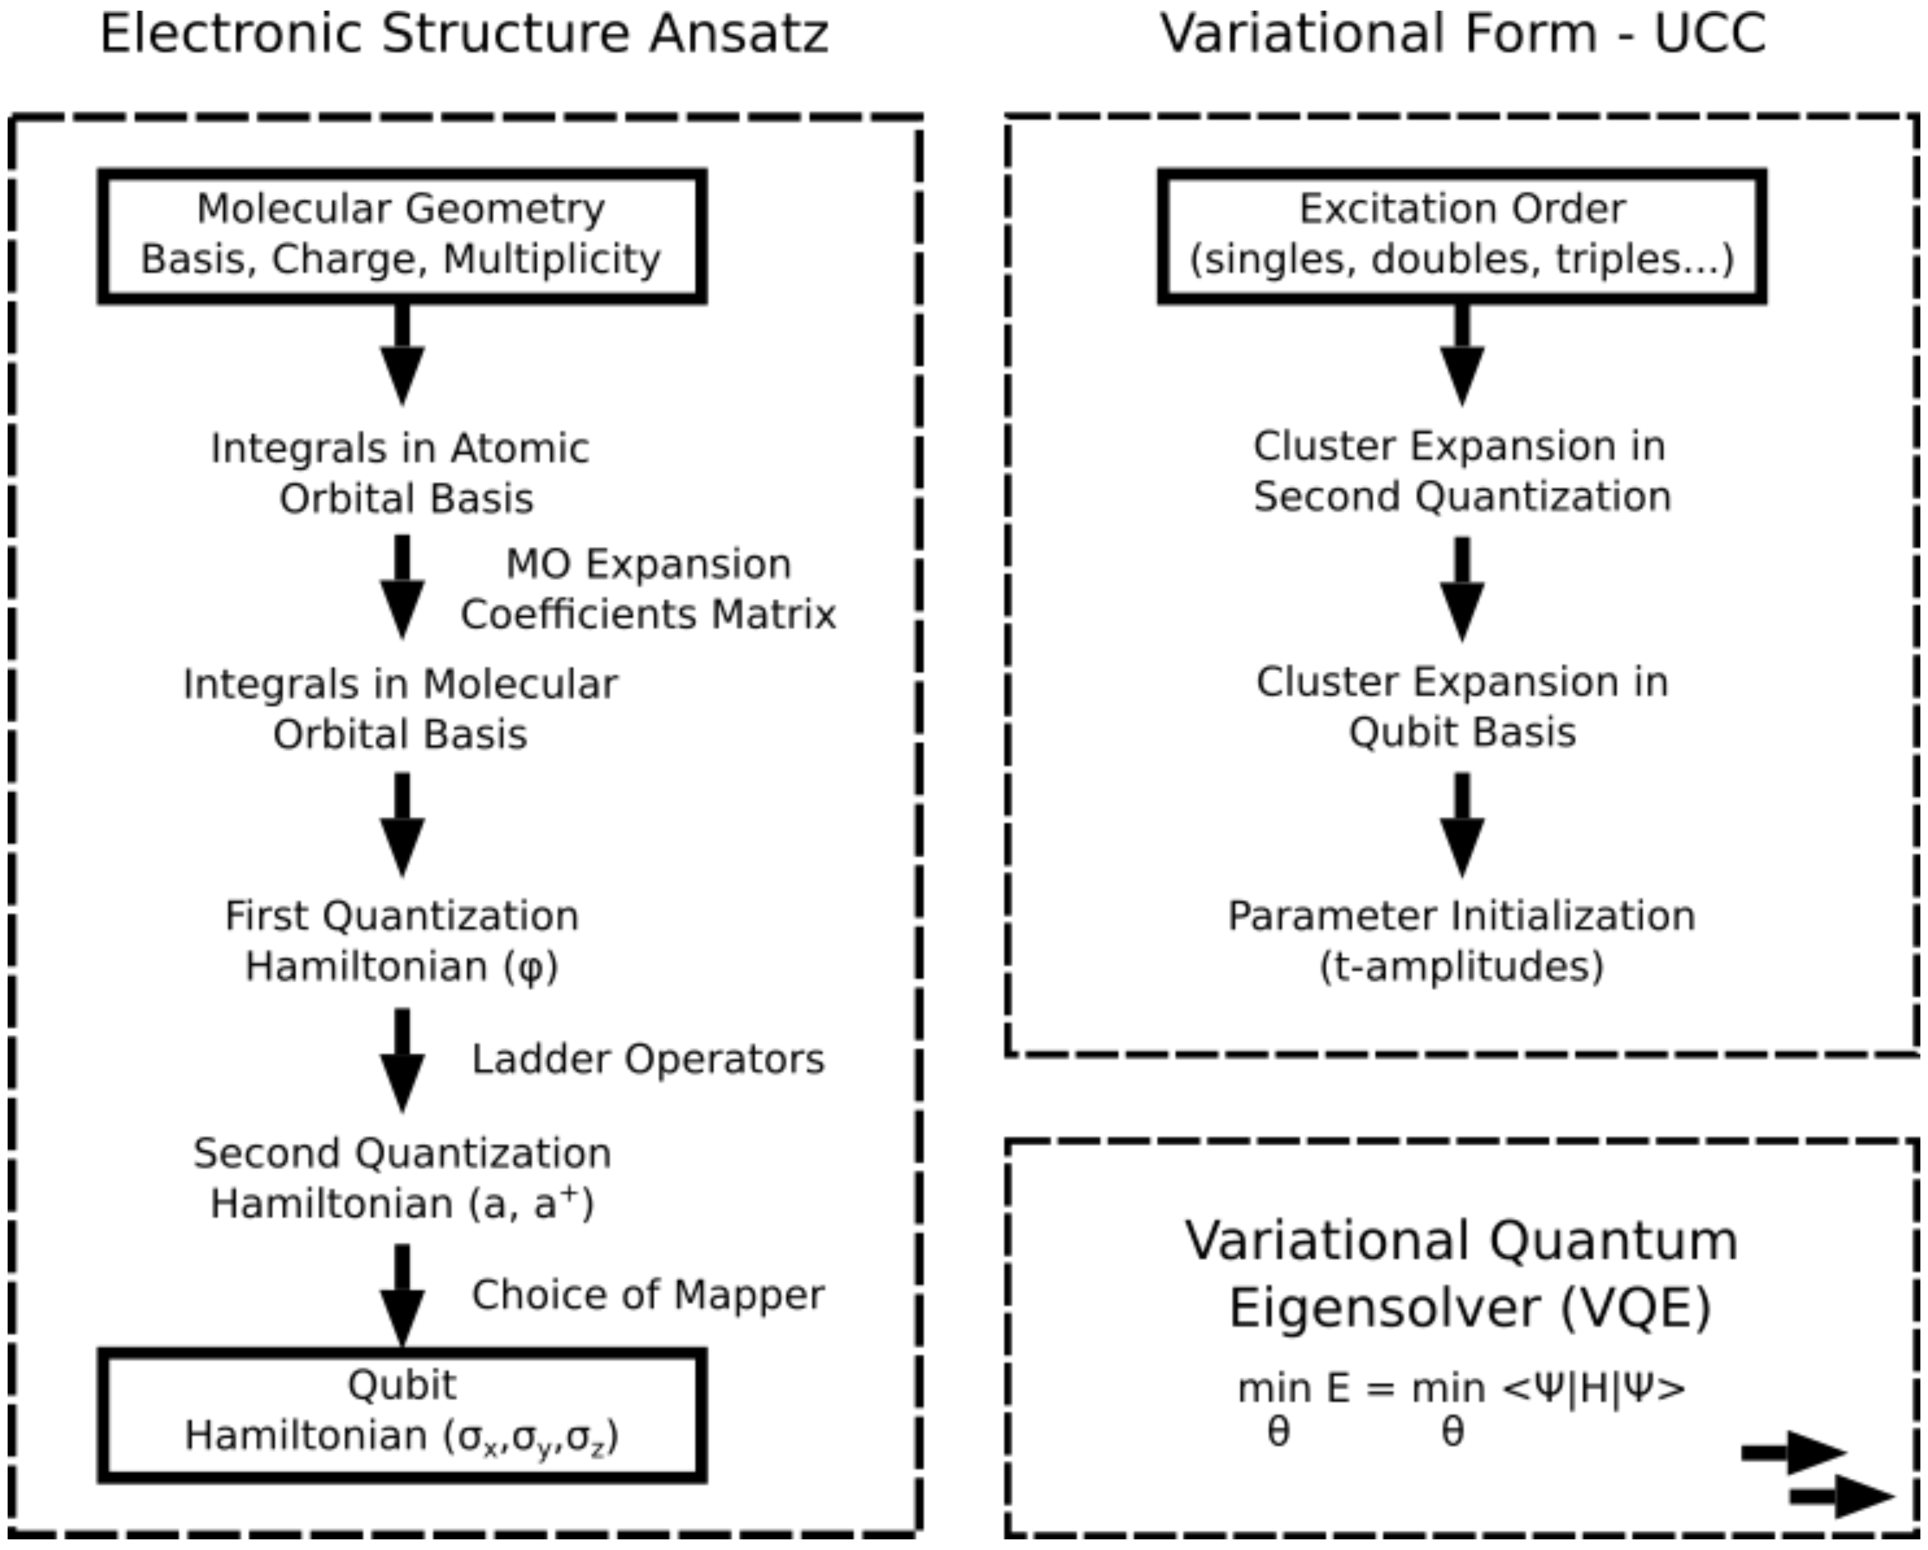

Note that the current class structure to perform a VQE calculation may be subject to change. In the version used in this tutorial each of the objects shoul should be organized in the following manner:

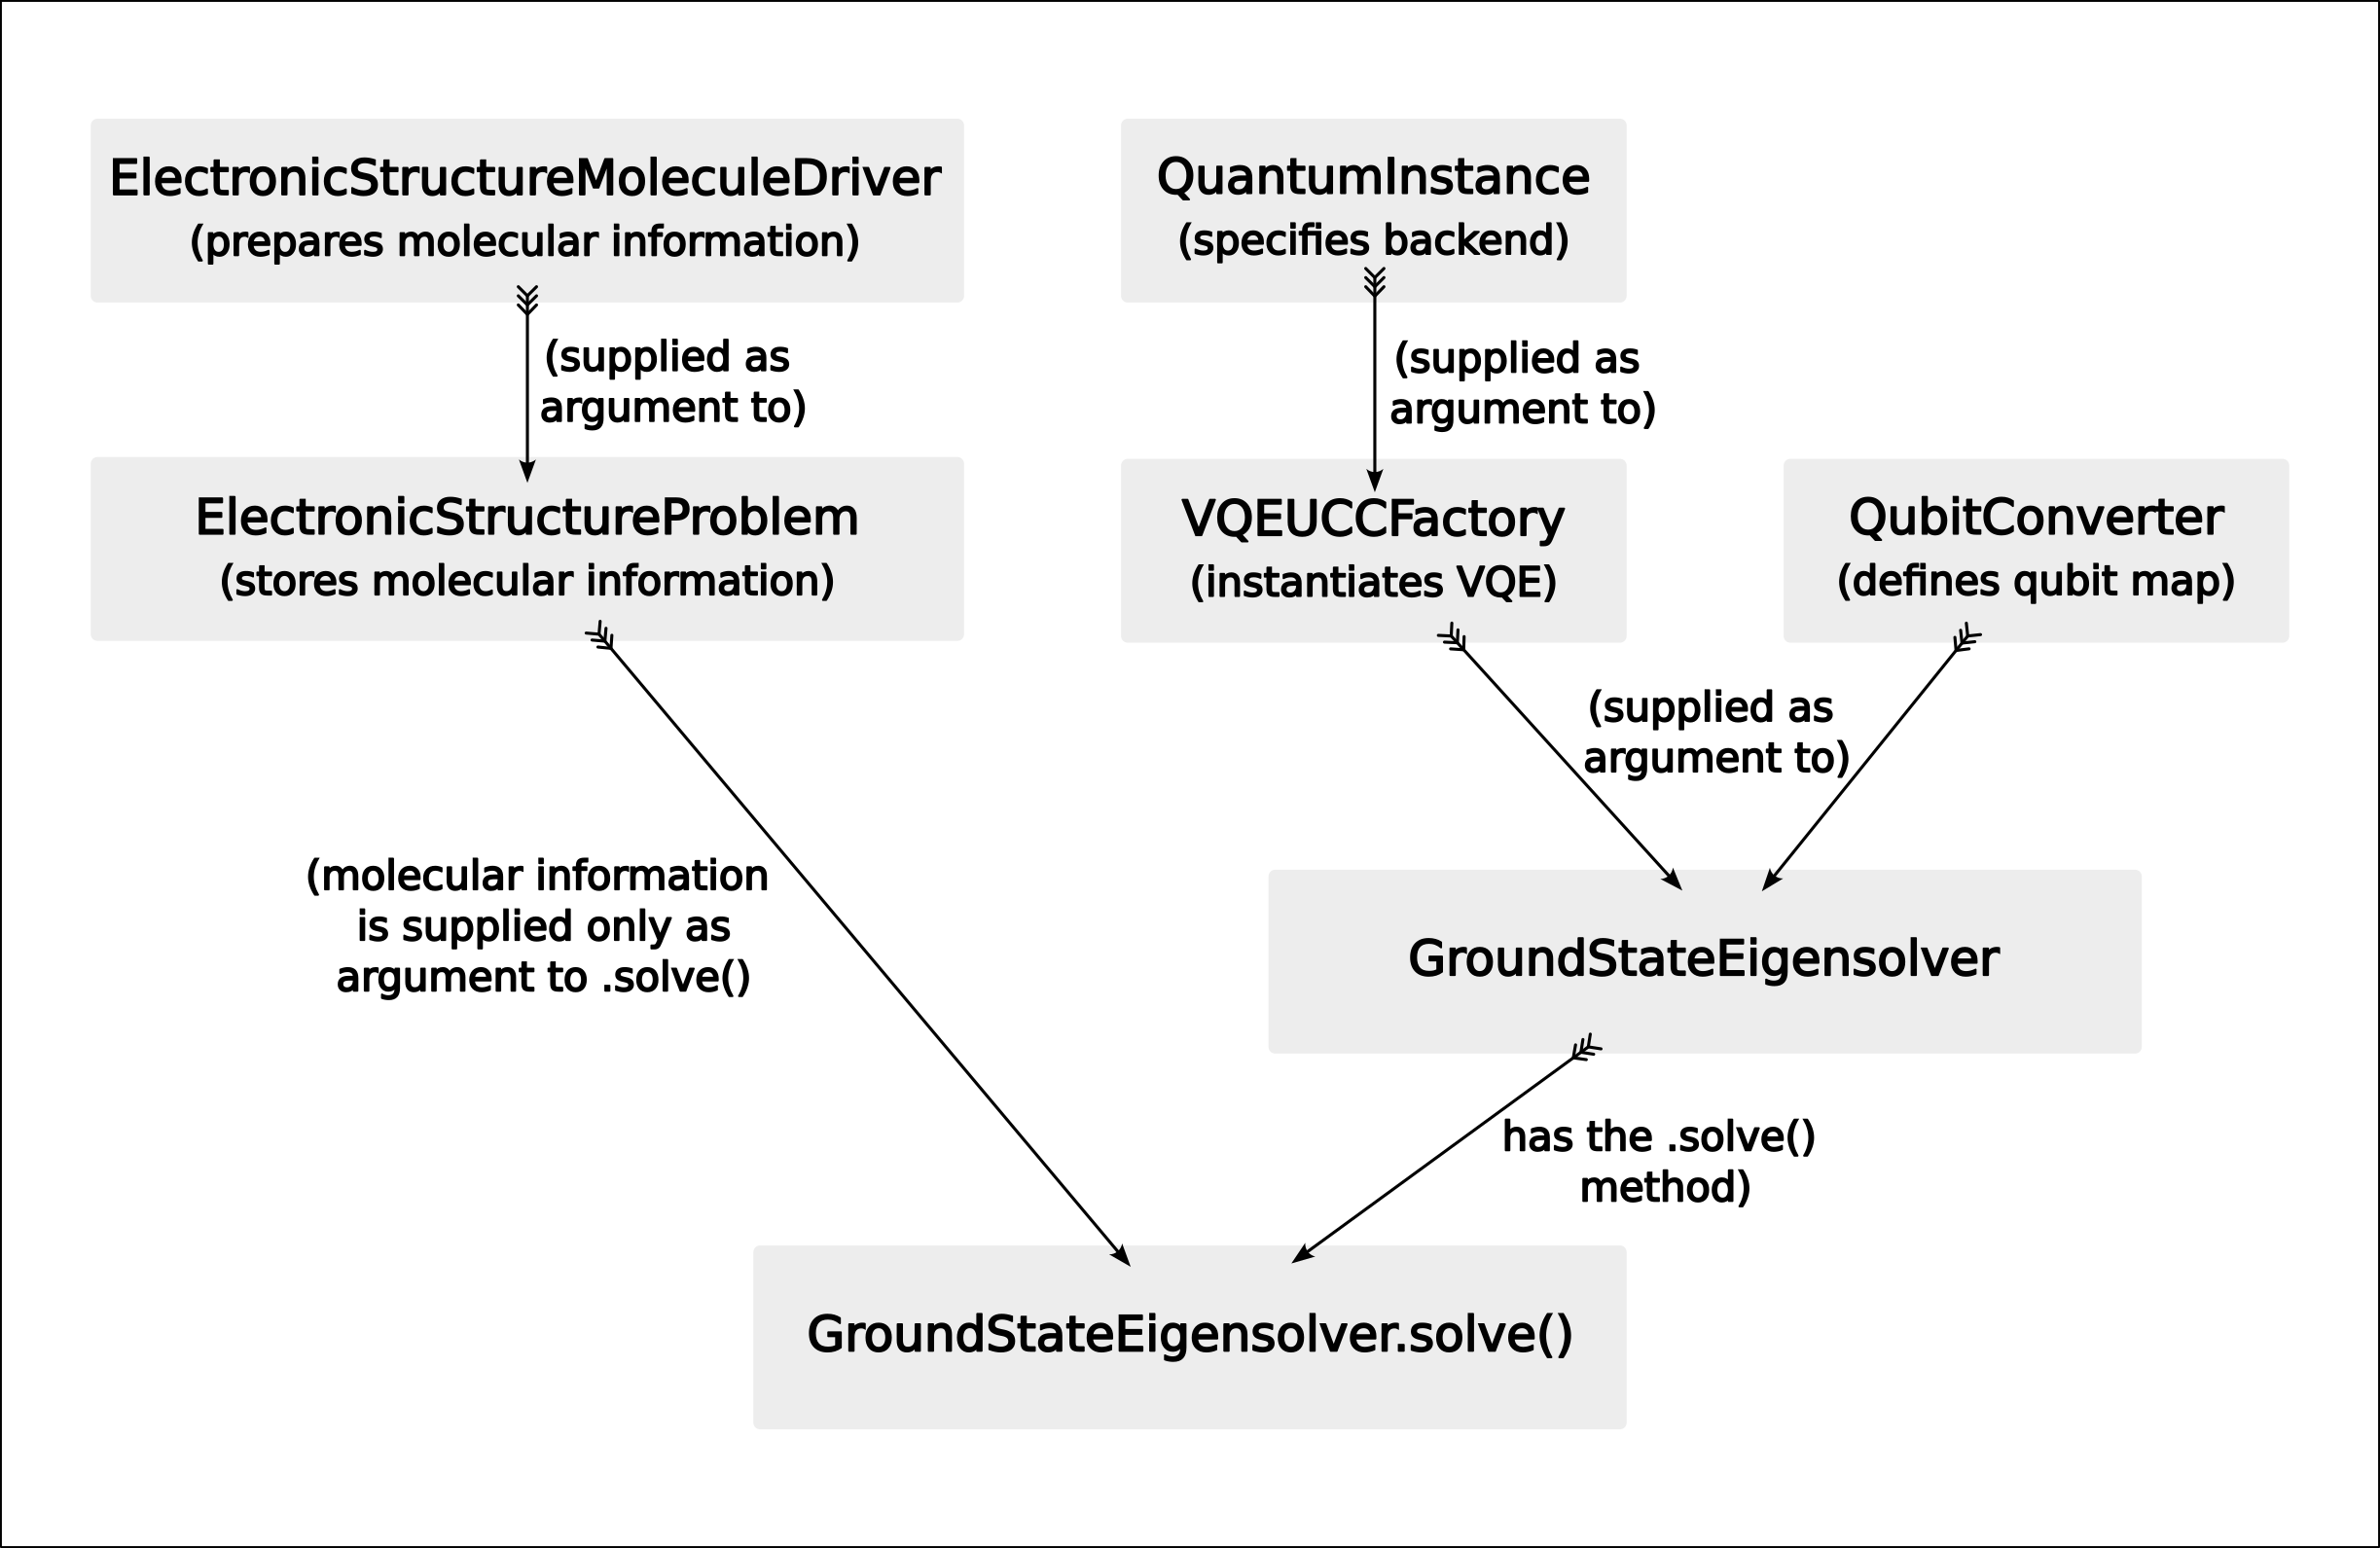

First we import the `Molecule` object from the `qiskit_nature.drivers` module. This can be supplied with a list of lists object containing the atomic `geometry`, the `charge` for the system and spin `multiplicity` (singlet = 1).

In [33]:
from qiskit_nature.drivers import Molecule

molecule = Molecule(
    geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 0.71414]]], charge=0, multiplicity=1
)

Then we use the `ElectronicStructureMoleculeDriver` object to instantiate a electronic structure calculation on a classical computer framework. Note that the default method for this calculation is Restricted Hartree-Fock, but other methods can be seen [here](https://qiskit.org/documentation/nature/stubs/qiskit_nature.drivers.second_quantization.MethodType.html#qiskit_nature.drivers.second_quantization.MethodType). Arguments provided include the `molecule` object produced above, the `basis` set (in this case `sto3g`, which contains a 1s spatial orbital for each hydrogen atom) and a specification of the `driver_type` as `ElectronicStructureDriverType.PYSCF` from the `qiskit_nature.drivers.second_quantization` module. Thus PySCF is used as the classical computer electronic structure software.

In [34]:
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver,
)

driver = ElectronicStructureMoleculeDriver(
    molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF 
)

This driver is then supplied as an argument to the `ElectronicStructureProblem` object for encoding into a form amenable for further processing.

In [35]:
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem

es_problem = ElectronicStructureProblem(driver)
print(es_problem)

We define a `QuantumInstance` using the `Aer` module to choose a backend and simulate the quantum computer framework on a classical machine.

In [36]:
from qiskit.utils import QuantumInstance
from qiskit import Aer

quantum_instance = QuantumInstance(backend=Aer.get_backend("aer_simulator_statevector"))

We import the `VQEUCCFactory` class which encodes the Variational Quantum Eigensolver algorithm, and is supplied with the `quantum_instance` backend chosen for the quantum part of the calculation.

In [37]:
from qiskit_nature.algorithms import VQEUCCFactory

vqe_solver = VQEUCCFactory(quantum_instance=quantum_instance)

Additionally, we use the `GroundStateEigensolver` object to solve the minimization problem for the ground state. As an argument we supplied the `qubit_converter` allowing encoding of the attributes of the classical computer electronic structure calculation into the qubit basis, alongside the specification of the `vqe_solver` object for quantum simulation. **Note that at this time no molecular information has been provided to any of these objects.**

In [38]:
from qiskit_nature.algorithms import GroundStateEigensolver

qubit_converter = QubitConverter(JordanWignerMapper())
calc = GroundStateEigensolver(qubit_converter, vqe_solver)

Obtaining the VQE electronic structure result requires calling the method `solve` from the `GroundStateEigensolver` class for the particular electronic structure problem, `es_problem`(which contains the molecular information):

In [39]:
res = calc.solve(es_problem)
print(res)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.877922738687
  - computed part:      -1.877922738687
~ Nuclear repulsion energy (Hartree): 0.740999259137
> Total ground state energy (Hartree): -1.136923479551
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.34952901]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.34952898]
    - computed part:      [0.0  0.0  1.34952898]
  > Dipole moment (a.u.): [0.0  0.0  0.00000003]  Total: 0.00000003
                 (debye): [0.0  0.0  0.00000007]  Total: 0.00000007
 


And this completes the application of the VQE algorithm to the $H_2$ molecule.

### ADAPT-VQE

Here we show how Qiskit's convenient [`AdaptVQE`](https://qiskit.org/documentation/nature/stubs/qiskit_nature.algorithms.AdaptVQE.html) class can be used to solve the same $H_2$ example problem. Here, we show a schematic that outlines the flow of the ADAPT-VQE algorithm to highlight how it differs from traditional VQE. 

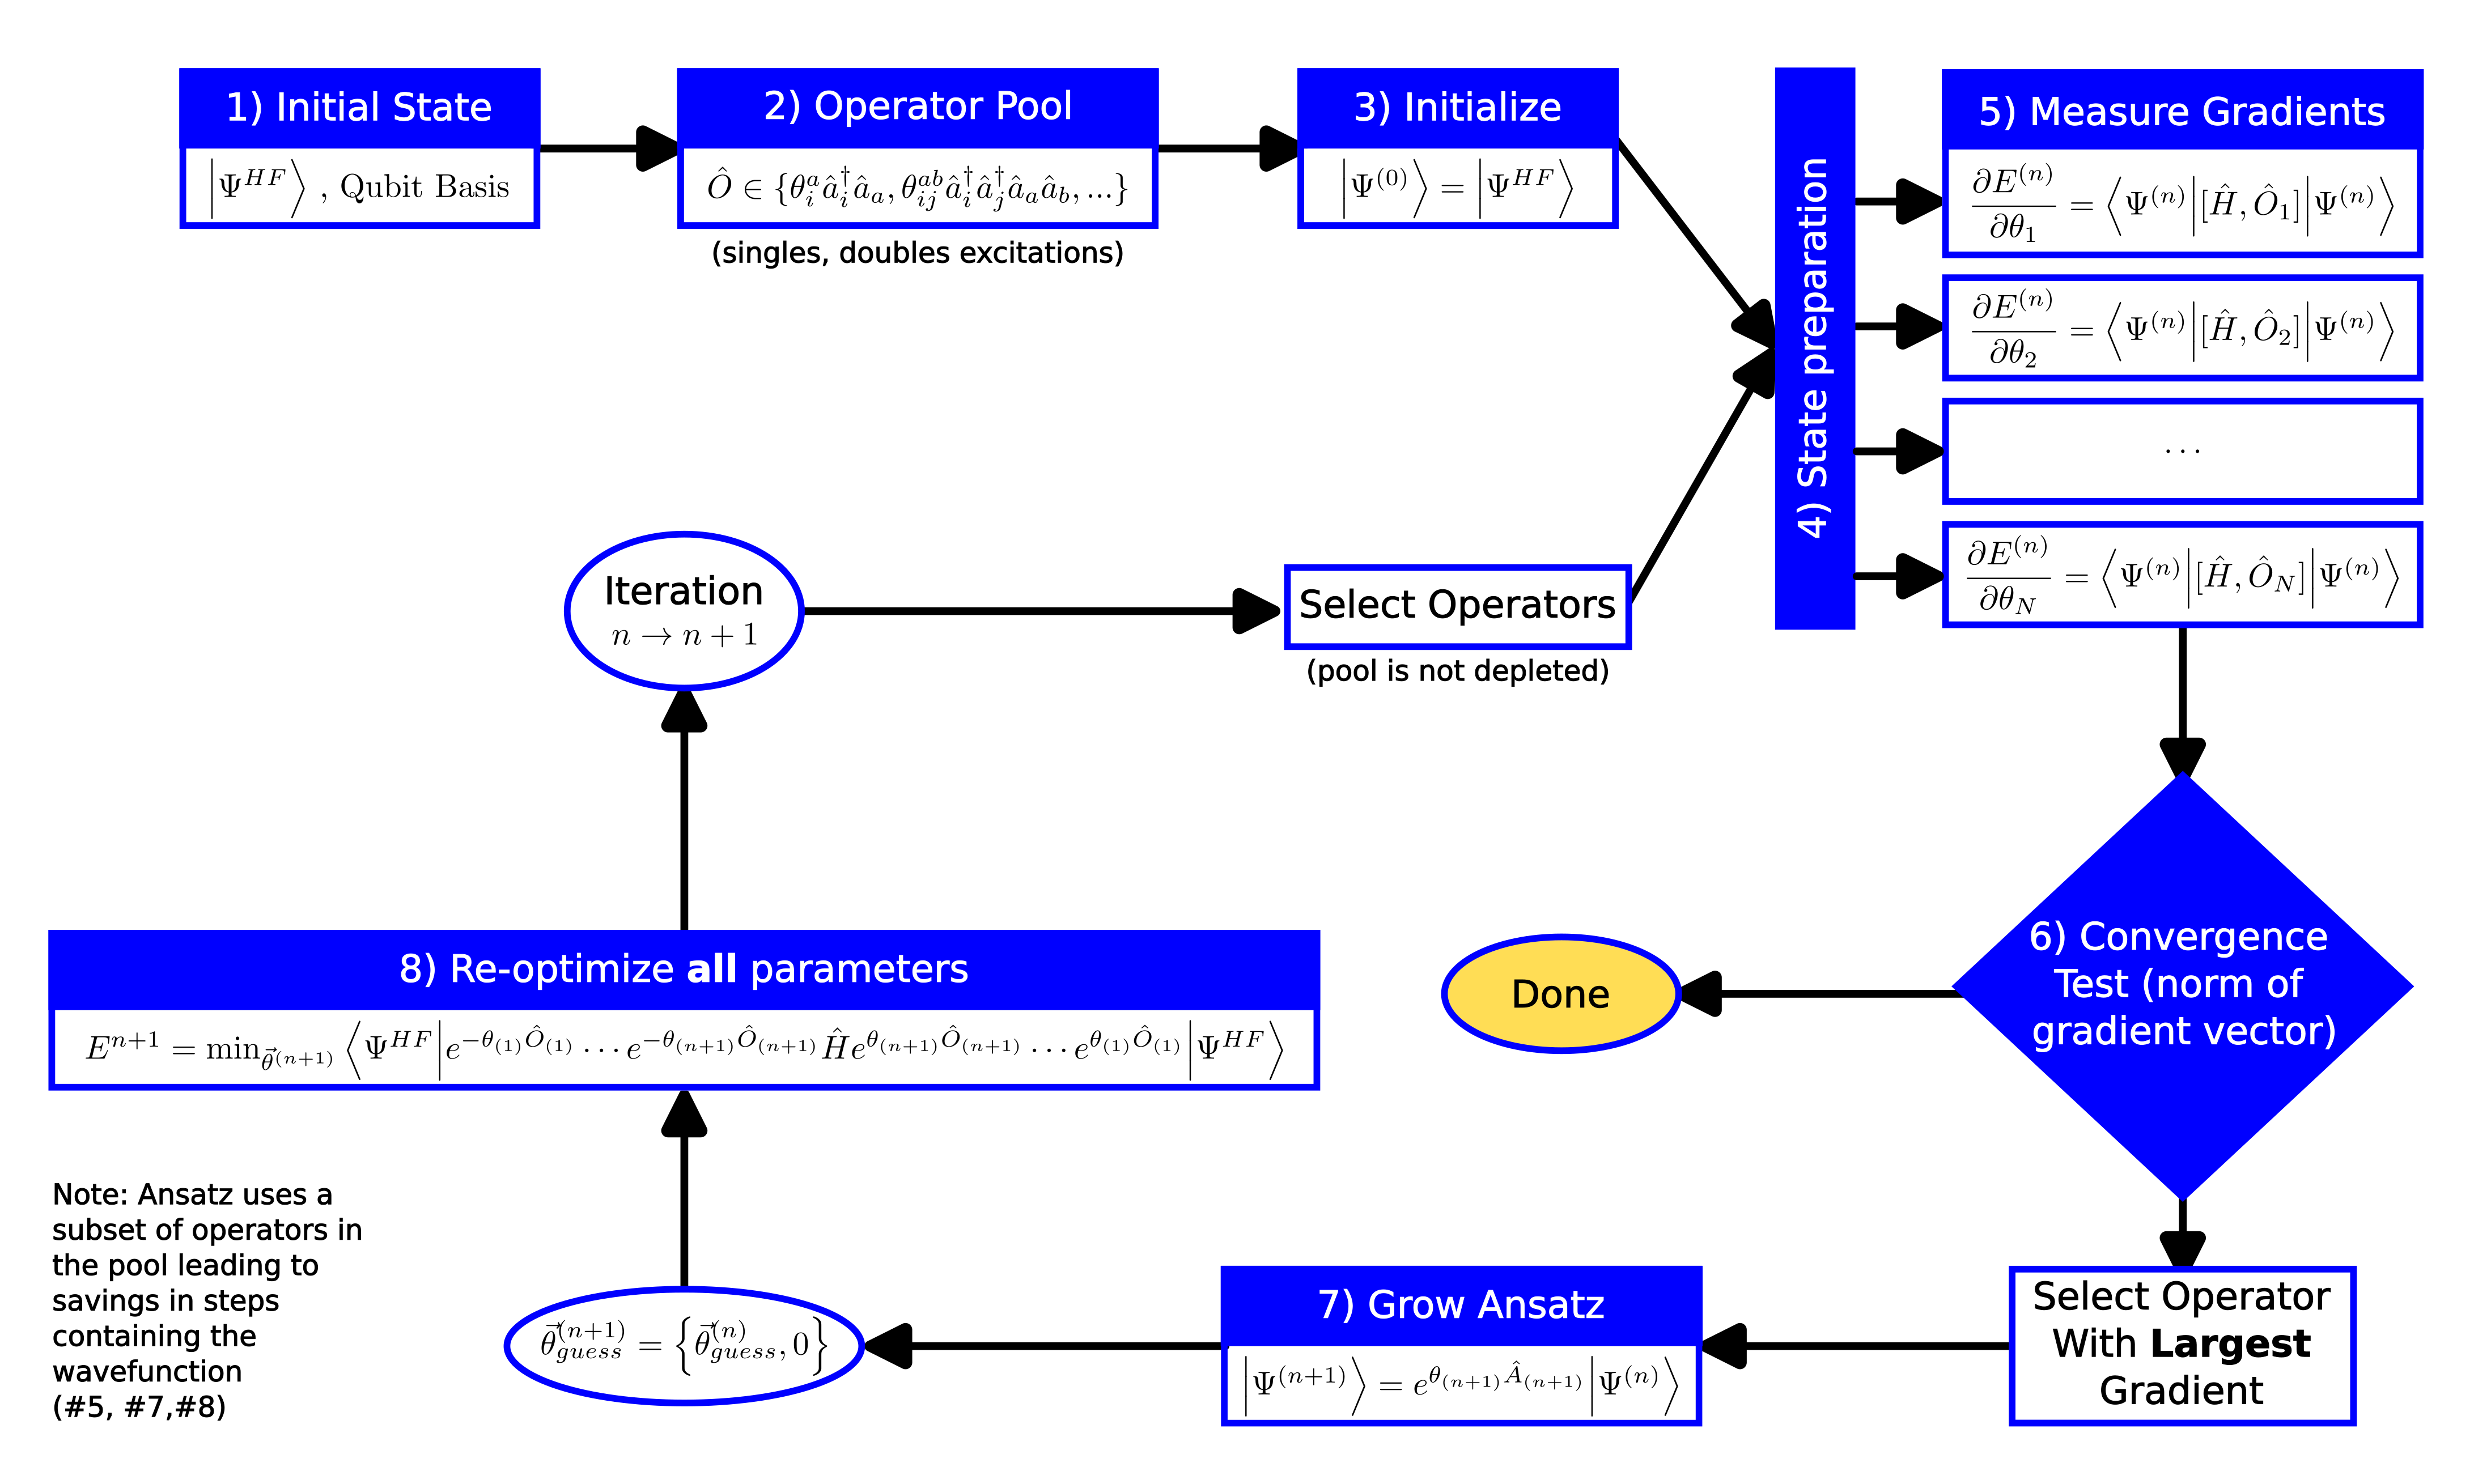

Image adapted from [Grimsley, H. R.; Economou, S. E.; Barnes, E.; Mayhall, N. J. An Adaptive Variational Algorithm for Exact Molecular Simulations on a Quantum Computer. Nat Commun 2019, 10 (1), 3007.](https://doi.org/10.1038/s41467-019-10988-2)

To accomplish this calculation, we import the `AdaptVQE` from the `qiskit_nature.algorithms` module. The arguments are similar to the VQE, except additional arguments are supplied such as `threshold` for the convergence test, `delta` for the parameter change and `max_iterations` to define the number of ADAPT cycles cuttoff.

In [40]:
from qiskit_nature.algorithms import AdaptVQE

adapt_calc = AdaptVQE(qubit_converter, vqe_solver, threshold=1e-1, delta=1e-2, max_iterations=100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: __init__: the delta argument is deprecated as of version 0.4.0 and will be removed no sooner than 3 months after the release. Instead use the gradient argument Instead of `delta=1.0` you have to construct a gradient, like so `gradient=Gradient(grad_method='fin_diff', epsilon=1.0)`..
  This is separate from the ipykernel package so we can avoid doing imports until


Analogously to VQE, we call the `solve` method using the choice of molecular information encoded in the electronic structure problem object, `es_problem`.

In [41]:
adapt_res = adapt_calc.solve(es_problem)

print(adapt_res)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.877922738687
  - computed part:      -1.877922738687
~ Nuclear repulsion energy (Hartree): 0.740999259137
> Total ground state energy (Hartree): -1.13692347955
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.34952901]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.34952901]
    - computed part:      [0.0  0.0  1.34952901]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.0
                 (debye): [0.0  0.0  -0.00000001]  Total: 0.00000001
 


# Application: NEO-VQE

* Read integrals
* Second quantization
* Qubit mapping

### The NEO Method

The nuclear electronic orbital (NEO) method allows the study of chemical problems beyond the Born-Oppenheimer approximation by treating some protons as quantum mechanical entities. This is accomplished by including terms in the Hamiltonian that describe the physics of the protons, while harnessing the quantum mechanical formalism/machinery routinely used for electronic structure. This applied example covers the [NEO Hartree-Fock method](https://manual.q-chem.com/5.3/Ch13.S4.SS1.html). The NEO-HF wavefunction is a product of the electronic and protonic wavefunction:

\begin{align*}
    \Psi _{\text{NEO-HF}} (\chi _e, \chi _p) = \Phi _{e} (\chi _e) \Phi _{p} (\chi _p) 
\end{align*}

Within the restricted NEO Hartree-Fock formalism the energy can be calculated:
\begin{multline*}
    E_{\text{NEO-HF}} = 
    2\sum_{i}^{N_{\text{e}}/2}h^{\text{e}}_{ii}+\sum_{i}^{N_{\text{e}}/2}\sum_{j}^{N_{\text{e}}/2}\Big{(}2(ii|jj)-(ij|ij)\Big{)} \\
    +\sum_{I}^{N_{\text{p}}}h^{\text{p}}_{II}+\frac{1}{2}\sum_{I}^{N_
{\text{p}}}\sum_{J}^{N_{\text{p}}}\Big{(}(II|JJ)-(IJ|IJ)\Big{)}-2\sum_{i}^{N_{\text{e}}/2}\sum_{I}^{N_{\text{p}}}(ii|II)
\end{multline*}

where $i,j$ denote electronic orbitals and $I,J$ denote nuclear orbitals.

Basis representation of electronic/protonic orbitals.
\begin{align*}
    \psi _{i} ^{e} = \sum _{\mu}^{N_e^{basis}} C _{\mu i}^{e} \phi _{\mu}^{e}(\mathbf{r}_e) \; ; \;
    \psi _{I} ^{p} = \sum _{\mu'}^{N_p^{basis}} C _{\mu ' I}^{p} \phi _{\mu'}^{p}(\mathbf{r}_p)
\end{align*}

The Hartree-Fock-Roothaan NEO equations are solved iteratively via a SCF procedure:
\begin{align*}
    \mathbf{F}^e\mathbf{C}^e = \mathbf{S}^e\mathbf{C}^e\mathbf{E}^e \; ; \;
    \mathbf{F}^p\mathbf{C}^p = \mathbf{S}^p\mathbf{C}^p\mathbf{E}^p
\end{align*}

The Fock matrix elements, for each iteration, contain mixed electronic-protonic terms:

\begin{align*}
    \mathbf{F}^e_{\mu \nu} &= h ^e_{\mu \nu} + \sum _{\rho \lambda} P ^e_{\lambda \rho} \Big( (\mu \nu| \rho \lambda) - \dfrac{1}{2}(\mu \lambda | \rho \nu) \Big) - \sum _{\mu' \nu'}P ^p_{\mu' \nu'} (\mu \nu|\mu' \nu') \\
    \mathbf{F}^p_{\mu \nu} &= h ^p_{\mu' \nu'} + \sum _{\rho' \lambda'} P ^p_{\lambda' \rho'} \Big( (\mu' \nu'| \rho' \lambda') - (\mu' \lambda' | \rho' \nu') \Big) - \sum _{\mu \nu}P ^e_{\mu \nu} (\mu' \nu'|\mu \nu)
\end{align*}

These integral elements can be calculated using standard electronic structure software packages/integrals libraries. For the purpose of this tutorial the terms are provided in a companion text file.

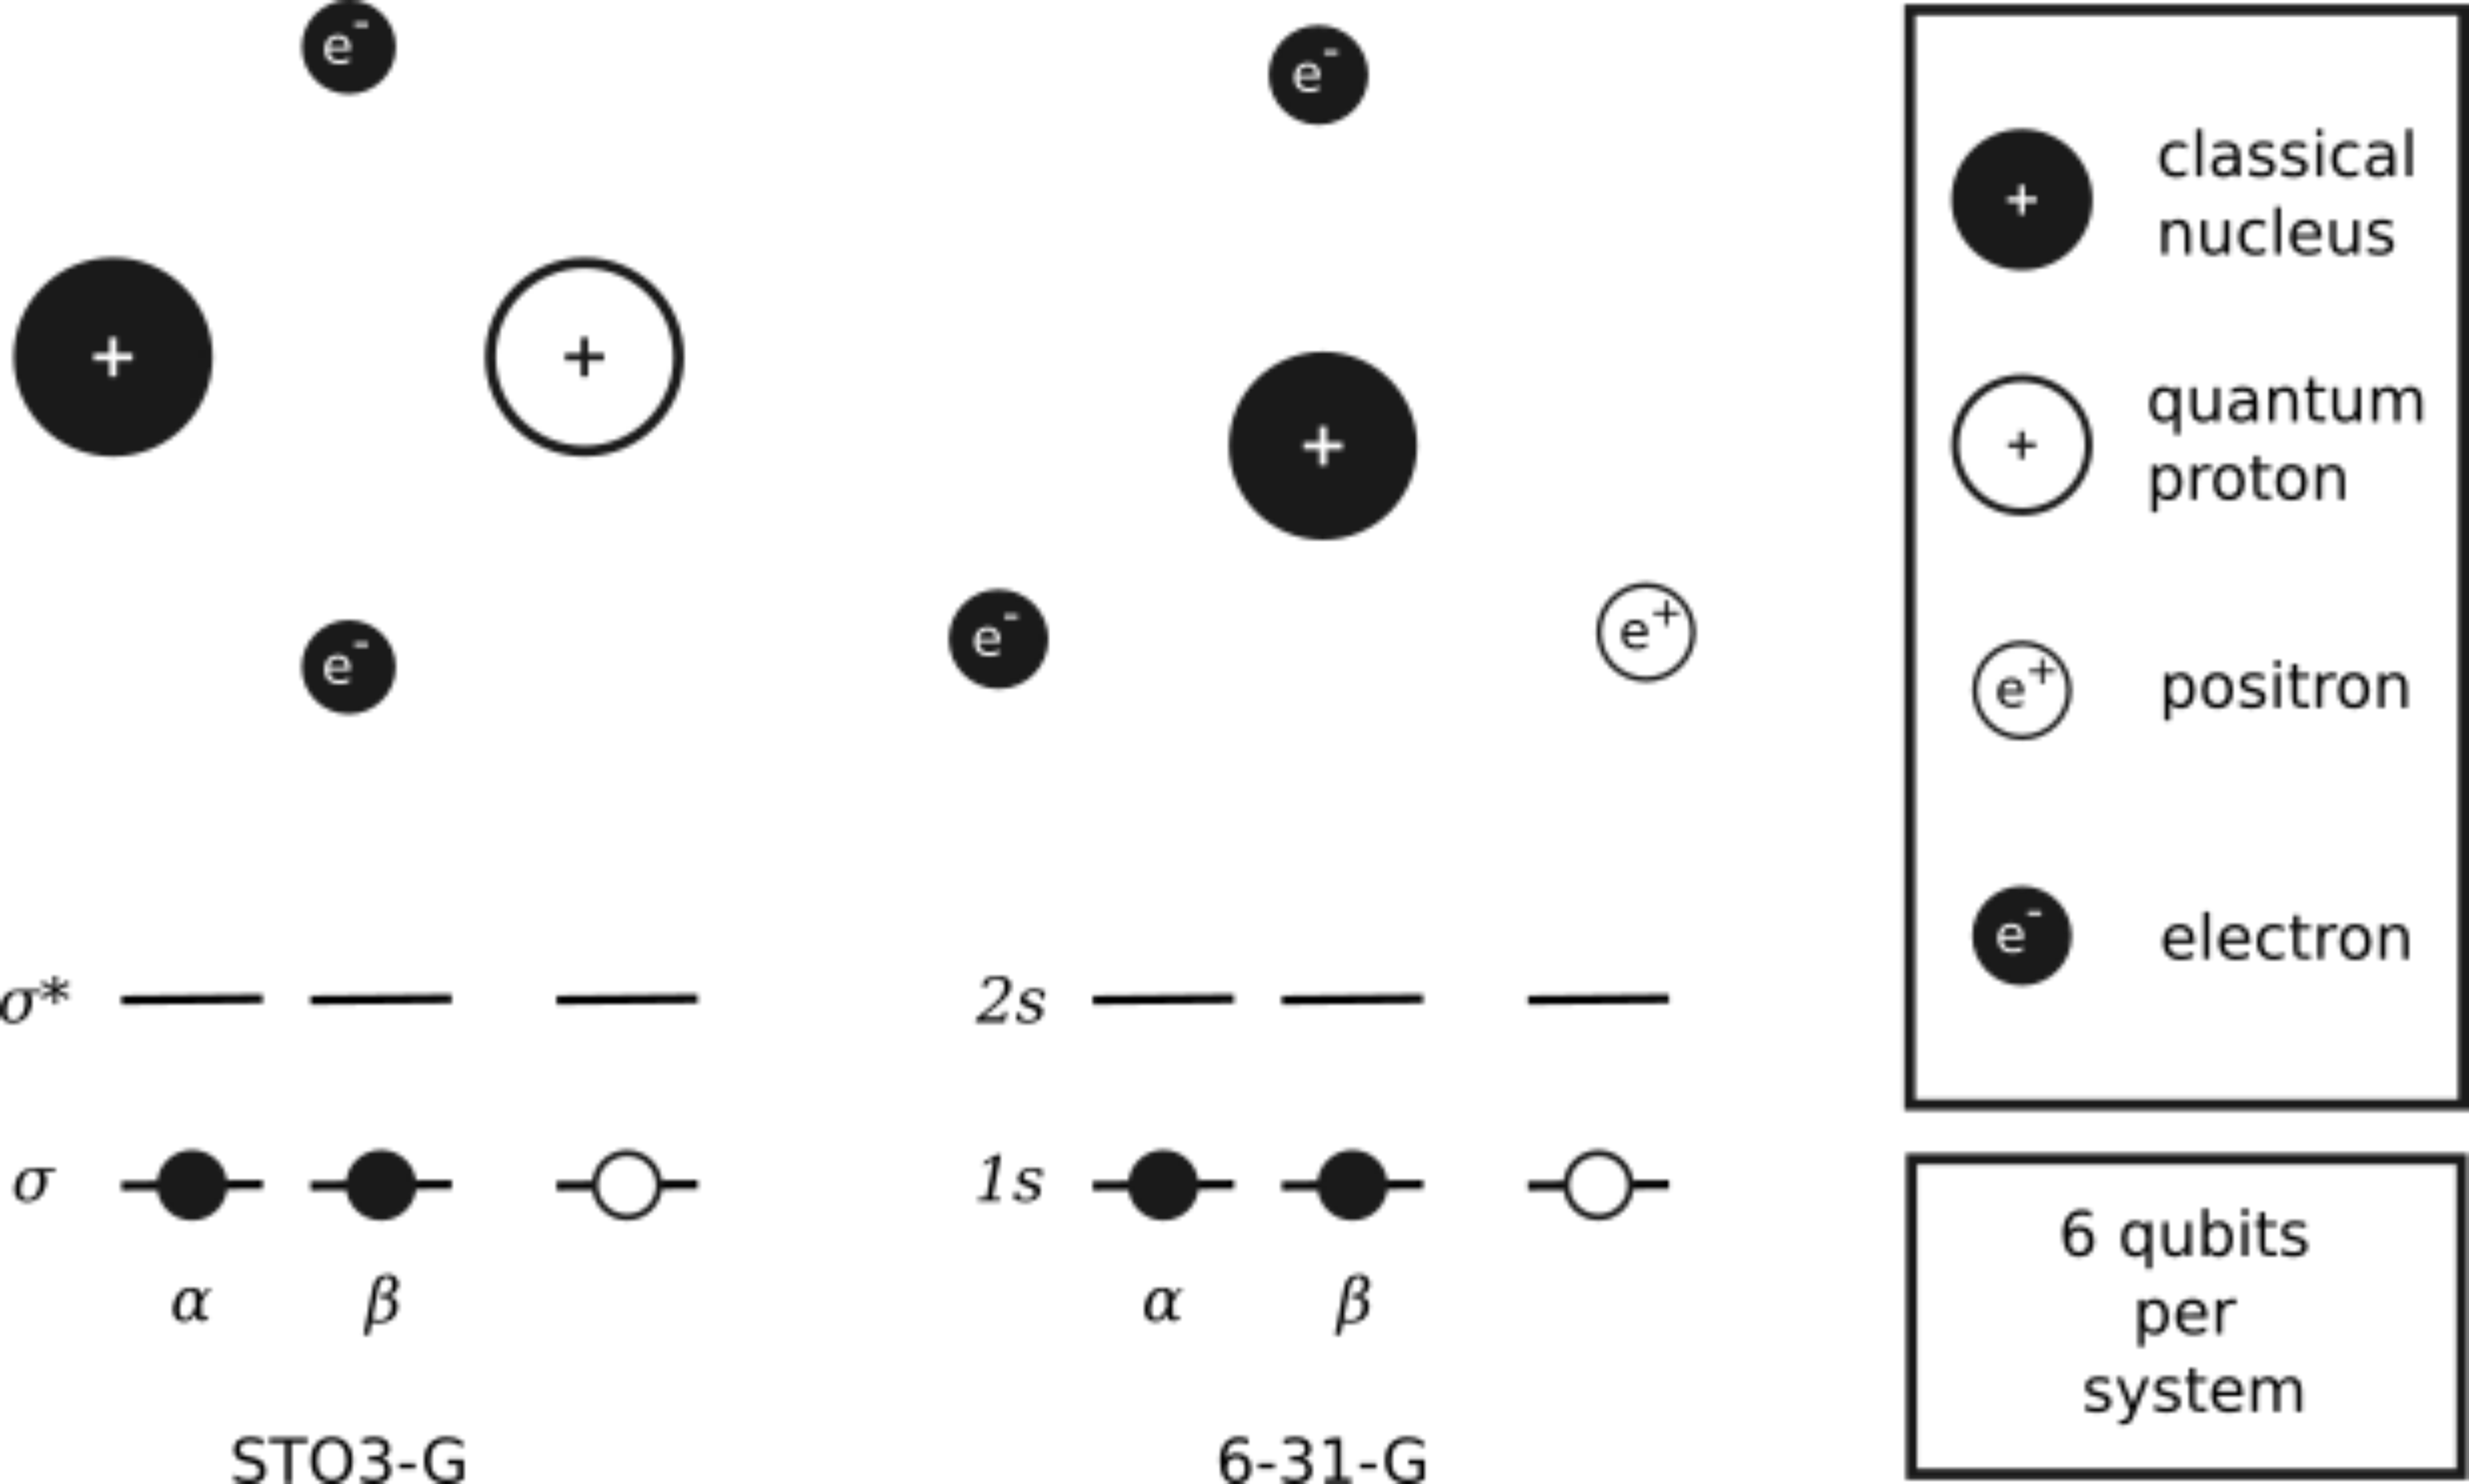

### Integral Reading


#### Description/Background

This notebook implements the Variational Quantum Eigensolver (VQE) using the multicomponent-Unitary Coupled Cluster (mcUCC) ansatz as introduced by Pavošević and Hammes-Schiffer in
[this paper](https://doi.org/10.1021/acs.jctc.1c00220) and seeks to build upon the original authors' methods by directly implementing these methods on a quantum computer. 

Although the Unitary Coupled Cluster ansatz has proven to be effective for many molecules **within the Born-Oppenheimer Approximation** (where electrons are treated quantum mechanically and nuclei are treated classically as a result of their mass being orders of magnitude larger), there are systems where this approximation is not valid. We will illustrate this with the two model systems utilized in the original publication: 

- $H_2$

- Positronium Hydride



#### Preliminary Codes

In [42]:
from qiskit import Aer, BasicAer
from qiskit.opflow import PauliExpectation, PauliTrotterEvolution, Suzuki, StateFn, PauliOp, X, Y, Z, I, One, Zero, VectorStateFn, CircuitStateFn, MatrixOp
from qiskit.circuit import ParameterVector
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA, L_BFGS_B
from qiskit.utils import QuantumInstance
from qiskit.quantum_info import Statevector, Operator
import numpy.linalg as LA 
# from qiskit_nature.circuit.library import UCCSD # Not currently used, but provides a streamlined class for generating a UCCSD ansatz.

# Dictionary that maps the string form of the Pauli Matrices to the Qiskit `PauliOps`
string2pauli = {'I': I, 'X': X, 'Y': Y, 'Z': Z}

# Begin Functions: 
def vec_query(arr, my_dict):
    '''
    This is a utility function that allows us to query a dict (i.e.; `my_dict`) 
    with a numpy array of keys. 
        Example Usage: Turn a Pauli String into a string of Pauli Matrices as recognized by Qiskit.
        init_string = ['I', 'X', 'Y', 'Z']
        out_string = vec_query(init_string, string2pauli)
    '''
    return np.vectorize(my_dict.__getitem__)(arr)



def construct_cluster_op(lead_term = 1):
    '''
    This function constructs a parameterized mc-UCCSD(T) ansatz.
    '''
    # Define our parameter vector corresponding to our t-amplitudes (reference Eqn. #)
    taus = ParameterVector('t_amps', length=5)

    # Electronic Double Excitations
    tau2_ee_JW = 0.125*lead_term*taus[0]*((-1. *  (X ^ X ^ X ^ Y ^ I ^ I)).eval() + (-1. * (X ^ X ^ Y ^ X ^ I ^ I)).eval() +
                                                   (X ^ Y ^ X ^ X ^ I ^ I).eval() + (-1. * (X ^ Y ^ Y ^ Y  ^ I ^ I)).eval() + 
                                                    (Y ^ X ^ X^ X ^ I ^ I).eval() + (-1. * (Y ^ X ^ Y ^ Y ^ I ^ I)).eval() + 
                                                   (Y ^ Y ^ X ^ Y ^ I ^ I).eval() + (Y ^ Y ^ Y ^ X ^ I ^ I ).eval())
    # Single Electronic Excitations 
    tau1_e_JW = 0.5*lead_term*taus[1]*((-1. * (X ^ Z ^ Y ^ I ^ I ^ I )).eval() + (Y ^ Z ^ X ^ I ^ I ^ I).eval() + 
                                        (- 1. * (I ^ X ^ Z ^ Y ^ I ^ I )).eval() + (I ^ Y ^ Z ^ X ^ I ^ I).eval())
    # Double Mixed Electronic-Protonic Excitations 
    tau2_ep_JW = 0.125* lead_term*taus[2]* ((X ^ Z ^ X ^ I ^ X ^ Y).eval() - (X ^ Z ^ X ^ I ^ Y ^ X).eval() +
                                            (X ^ Z ^ Y ^ I ^ X ^ X).eval() + (X ^ Z ^ Y ^ I ^ Y ^ Y).eval() - 
                                            (Y ^ Z ^ X ^ I ^ X ^ X).eval() + (Y ^ Z ^ X ^ I ^ Y ^ Y).eval() + 
                                            (Y ^ Z ^ Y ^ I ^ X ^ Y).eval() - (Y ^ Z ^ Y ^ I ^ Y ^ X).eval() +
                                            (I ^ X ^ Z ^ X ^ X ^ Y).eval() - (I ^ X ^ Z ^ X ^ Y ^ X).eval() +
                                            (I ^ X ^ Z ^ Y ^ X ^ X).eval() + (I ^ X ^ Z ^ Y ^ Y ^ Y).eval() -
                                            (I ^ Y ^ Z ^ X ^ X ^ X).eval() - (I ^ Y ^ Z ^ X ^ Y ^ Y).eval() + 
                                            (I ^ Y ^ Z ^ Y ^ X ^ Y).eval() - (I ^ Y ^ Z ^ Y ^ Y ^ X).eval())
    # Single Protonic Excitations
    tau1_p_JW = 0.5*lead_term*taus[3]*((I ^ I ^ I ^ I ^ X ^ Y).eval() - (I ^ I ^ I ^ I ^ Y ^ X).eval())
    # Triple Mixed Electronic-Protonic Excitations
    tau3_eep_JW = 0.03125*lead_term*taus[4]*((-1.*(X ^ X ^ X ^ X ^ X ^ Y)).eval() + (X ^ X ^ X ^ X ^ Y ^ X).eval() -
                                                 (X ^ X ^ X ^ Y ^ X ^ X).eval() - (X ^ X ^ X ^ Y ^ Y ^ Y).eval() -
                                                 (X ^ X ^ Y ^ X ^ X ^ X).eval() - (X ^ X ^ Y ^ X ^ Y ^ Y).eval() +
                                                 (X ^ X ^ Y ^ Y ^ X ^ Y).eval() - (X ^ X ^ Y ^ Y ^ Y ^ X).eval() +
                                                 (X ^ Y ^ X ^ X ^ X ^ X).eval() + (X ^ Y ^ X ^ X ^ Y ^ Y).eval() -
                                                 (X ^ Y ^ X ^ Y ^ X ^ Y).eval() + (X ^ Y ^ X ^ Y ^ Y ^ X).eval() -
                                                 (X ^ Y ^ Y ^ X ^ X ^ Y).eval() + (X ^ Y ^ Y ^ X ^ Y ^ X).eval() -
                                                 (X ^ Y ^ Y ^ Y ^ X ^ X).eval() - (X ^ Y ^ Y ^ Y ^ Y ^ Y).eval() +
                                                 (Y ^ X ^ X ^ X ^ X ^ X).eval() + (Y ^ X ^ X ^ X ^ Y ^ Y).eval() -
                                                 (Y ^ X ^ X ^ Y ^ X ^ Y).eval() + (Y ^ X ^ X ^ Y ^ Y ^ X).eval() -
                                                 (Y ^ X ^ Y ^ X ^ X ^ Y).eval() + (Y ^ X ^ Y ^ X ^ Y ^ X).eval() -
                                                 (Y ^ X ^ Y ^ Y ^ X ^ X).eval() - (Y ^ X ^ Y ^ Y ^ Y ^ Y).eval() -
                                                 (Y ^ Y ^ X ^ X ^ X ^ Y).eval() - (Y ^ Y ^ X ^ X ^ Y ^ X).eval() +
                                                 (Y ^ Y ^ X ^ Y ^ X ^ X).eval() + (Y ^ Y ^ X ^ Y ^ Y ^ Y).eval() +
                                                 (Y ^ Y ^ Y ^ X ^ X ^ X).eval() + (Y ^ Y ^ Y ^ X ^ Y ^ Y).eval() -
                                                 (Y ^ Y ^ Y ^ Y ^ X ^ Y).eval() + (Y ^ Y ^ Y ^ Y ^ Y ^ X).eval())
    cluster_terms = tau2_ee_JW + tau1_e_JW + tau2_ep_JW + tau1_p_JW + tau3_eep_JW
    cluster_op = cluster_terms.exp_i()
    return cluster_op 


def bind_operator_params(operator_name, values):
    '''
    Utility function to bind values of a parameterized operator.
    '''
    n_params = len(operator_name.parameters)
    operator_name.bind_parameters(dict(zip(operator_name.parameters, values)))
    return operator_name

np.set_printoptions(suppress=True)

NEO_Ham = ((0.08050183366921762)   * (I ^  I ^  I ^  I ^  I ^  I) 
        + (-0.04516478087448256)  * (X ^  X ^  Y ^  Y ^  I ^  I) 
        + (0.04516478087448256)   * (X ^  Y ^  Y ^  X ^  I ^  I) 
        + (0.028238626330481964)  * (X ^  Z ^  X ^  I ^  I ^  I) 
        + (-0.002433078613602)    * (X ^  Z ^  X ^  Z ^  I ^  I) 
        + (-0.001085353956284875) * (X ^  Z ^  X ^  I ^  X ^  X) 
        + (-0.001085353956284875) * (X ^  Z ^  X ^  I ^  Y ^  Y) 
        + (0.08610133233766938)   * (X ^  Z ^  X ^  I ^  Z ^  I) 
        + (0.06289875071602763)   * (X ^  Z ^  X ^  I ^  I ^  Z) 
        + (0.002602966095228563)  * (X ^  I ^  X ^  I ^  I ^  I) 
        + (0.04516478087448256)   * (Y ^  X ^  X ^  Y ^  I ^  I) 
        + (-0.04516478087448256)  * (Y ^  Y ^  X ^  X ^  I ^  I) 
        + (0.028238626330481964)  * (Y ^  Z ^  Y ^  I ^  I ^  I) 
        + (-0.002433078613602)    * (Y ^  Z ^  Y ^  Z ^  I ^  I) 
        + (-0.001085353956284875) * (Y ^  Z ^  Y ^  I ^  X ^  X) 
        + (-0.001085353956284875) * (Y ^  Z ^  Y ^  I ^  Y ^  Y) 
        + (0.08610133233766938)   * (Y ^  Z ^  Y ^  I ^  Z ^  I) 
        + (0.06289875071602763)   * (Y ^  Z ^  Y ^  I ^  I ^  Z) 
        + (0.002602966095228563)  * (Y ^  I ^  Y ^  I ^  I ^  I) 
        + (0.14194074833434972)   * (Z ^  I ^  I ^  I ^  I ^  I) 
        + (0.002602966095228563)  * (Z ^  X ^  Z ^  X ^  I ^  I) 
        + (0.002602966095228563)  * (Z ^  Y ^  Z ^  Y ^  I ^  I) 
        + (0.168803262630486)     * (Z ^  Z ^  I ^  I ^  I ^  I) 
        + (0.12057651604485276)   * (Z ^  I ^  Z ^  I ^  I ^  I) 
        + (0.16574129691933526)   * (Z ^  I ^  I ^  Z ^  I ^  I) 
        + (0.00061548930662275)   * (Z ^  I ^  I ^  I ^  X ^  X) 
        + (0.00061548930662275)   * (Z ^  I ^  I ^  I ^  Y ^  Y) 
        + (-0.220267448058864)    * (Z ^  I ^  I ^  I ^  Z ^  I) 
        + (-0.20280478223967474)  * (Z ^  I ^  I ^  I ^  I ^  Z) 
        + (0.028238626330481964)  * (I ^  X ^  Z ^  X ^  I ^  I) 
        + (-0.001085353956284875) * (I ^  X ^  Z ^  X ^  X ^  X) 
        + (-0.001085353956284875) * (I ^  X ^  Z ^  X ^  Y ^  Y) 
        + (0.08610133233766938)   * (I ^  X ^  Z ^  X ^  Z ^  I) 
        + (0.06289875071602763)   * (I ^  X ^  Z ^  X ^  I ^  Z) 
        + (-0.002433078613602)    * (I ^  X ^  I ^  X ^  I ^  I) 
        + (0.028238626330481964)  * (I ^  Y ^  Z ^  Y ^  I ^  I) 
        + (-0.001085353956284875) * (I ^  Y ^  Z ^  Y ^  X ^  X) 
        + (-0.001085353956284875) * (I ^  Y ^  Z ^  Y ^  Y ^  Y) 
        + (0.08610133233766938)   * (I ^  Y ^  Z ^  Y ^  Z ^  I) 
        + (0.06289875071602763)   * (I ^  Y ^  Z ^  Y ^  I ^  Z) 
        + (-0.002433078613602)    * (I ^  Y ^  I ^  Y ^  I ^  I) 
        + (0.14194074833434972)   * (I ^  Z ^  I ^  I ^  I ^  I) 
        + (0.16574129691933526)   * (I ^  Z ^  Z ^  I ^  I ^  I) 
        + (0.12057651604485276)   * (I ^  Z ^  I ^  Z ^  I ^  I) 
        + (0.00061548930662275)   * (I ^  Z ^  I ^  I ^  X ^  X) 
        + (0.00061548930662275)   * (I ^  Z ^  I ^  I ^  Y ^  Y) 
        + (-0.220267448058864)    * (I ^  Z ^  I ^  I ^  Z ^  I) 
        + (-0.20280478223967474)  * (I ^  Z ^  I ^  I ^  I ^  Z) 
        + (-0.2791676157167482)   * (I ^  I ^  Z ^  I ^  I ^  I) 
        + (0.17451848726278274)   * (I ^  I ^  Z ^  Z ^  I ^  I) 
        + (0.00171166584424575)   * (I ^  I ^  Z ^  I ^  X ^  X) 
        + (0.00171166584424575)   * (I ^  I ^  Z ^  I ^  Y ^  Y) 
        + (-0.244952026082031)    * (I ^  I ^  Z ^  I ^  Z ^  I) 
        + (-0.2129541339465055)   * (I ^  I ^  Z ^  I ^  I ^  Z) 
        + (-0.2791676157167481)   * (I ^  I ^  I ^  Z ^  I ^  I) 
        + (0.00171166584424575)   * (I ^  I ^  I ^  Z ^  X ^  X) 
        + (0.00171166584424575)   * (I ^  I ^  I ^  Z ^  Y ^  Y) 
        + (-0.244952026082031)    * (I ^  I ^  I ^  Z ^  Z ^  I) 
        + (-0.2129541339465055)   * (I ^  I ^  I ^  Z ^  I ^  Z) 
        + (-0.0021923530752455)   * (I ^  I ^  I ^  I ^  X ^  X) 
        + (-0.0021923530752455)   * (I ^  I ^  I ^  I ^  Y ^  Y) 
        + (0.5687811831182695)    * (I ^  I ^  I ^  I ^  Z ^  I) 
        + (0.47117012280981496)   * (I ^  I ^  I ^  I ^  I ^  Z))


First, we should define our initial state/guess wavefunction. This is the so-called multicomponent Hartree-Fock Wavefunction: 

$$ \left| \Psi_{\textrm{HF}} \right \rangle = \left| \psi_{e} \right \rangle \left| \psi_{p} \right \rangle $$ 

In [43]:
def get_mcHF_initial_state():
    '''
    This is a utility function to generate the multicomponent-Hartree Fock Wavefunction
    '''
    # Definition of the multicomponent Hartree-Fock State (mcHF):
    # Initial Electronic Wavefunction (Electronic Slater Determinant):
    psi0e = One ^ One ^ Zero ^ Zero
    # Initial Protonic Wavefunction (Protonic Slater Determinant):
    psi0p = One ^ Zero
    # Construct the wavefunction from the tensor produce of the electronic and protonic components.
    mc_HF = psi0e ^ psi0p
    # Define it as a `qiskit.VectorStateFn` Object - 
    # this is needed for us to apply the UCC operator later
    init_state = VectorStateFn(mc_HF.to_matrix())
    return init_state

In [44]:
psi0 = get_mcHF_initial_state() # Generate the initial wavefunction. 
Statevector(psi0.to_matrix()).draw('latex') # Here we're just showing the ket for the mc-HF wavefunction.

<IPython.core.display.Latex object>

In [45]:
# Take our Hamiltonian (defined in the J-W Basis above)
new_ham = NEO_Ham


With the initial wavefunction and our Hamiltonian, we can get the energy of our initial guess (i.e., mc-Hartree Fock Energy) by computing the expectation value: $$ E_{mcHF} = \left\langle \psi_{mcHF} \middle| H \middle| \psi_{mcHF} \right \rangle $$ 

In [46]:
# Calculate the HF Energy by computing the expectation value: <psi | H | psi>
HF_energy = Statevector(psi0.to_matrix()).expectation_value(new_ham)
fabijan_HF_en = -1.059569378143867
print("HF Energy:\t{}\nDifference from reported HF Energy:\t{}".format(np.real(HF_energy), 
                                                                                 np.real(HF_energy-fabijan_HF_en)))

HF Energy:	-1.0595693781438675
Difference from reported HF Energy:	-4.440892098500626e-16


In [47]:
# Construct the parameterized UCC operator/propagator in the JW basis:
cluster_prop = construct_cluster_op(lead_term=1.0)
# Now we need to convert the circuit so its actually recognizeably by a QC: 
# Trotterize the cluster propagator: 
trotterized_clust = PauliTrotterEvolution(trotter_mode=Suzuki(order=1, reps=1)).convert(cluster_prop)
# We have to initialize our t-amplitudes (the parameterized amplitudes of the terms in the cluster expansion)
bound_trotter_clust = bind_operator_params(trotterized_clust, [0.0]*5)
# Reduce the expression 
cluster_circuit = bound_trotter_clust.reduce()
# Now we will generate our ansatz/variational form by applying 
# the cluster propagator to the initial state and generate its circuit.
var_form = (cluster_circuit.compose(psi0)).to_circuit()
# Restrict the bounds of the t-amplitudes to be within the range of {-0.5, 0.5}:
var_form.parameter_bounds = [[-0.5, 0.5]]*5

Now we will set-up and run our VQE Run! Note that you can find explanations of the optional arguments [here](https://qiskit.org/documentation/stubs/qiskit.algorithms.VQE.html): 

In [48]:
#------------------------- Parameters for Classical Optimizer -------------------------#
max_funk = 2500 # Maximum Number of Function Executions
max_iterations = 2000 # Maximum Number of VQE Iterations
# Now we define our classical optimizer
optim_bfgs = L_BFGS_B(maxfun=max_funk, maxiter=max_iterations, max_evals_grouped=1)
#------------------------- Initialize the Backend Configuration for Circuit Execution -------------------------# 
backend = BasicAer.get_backend('statevector_simulator')
#------------------------- Construct a QuantumInstance for our QuantumCircuit Simulator -------------------------# 
qi = QuantumInstance(backend, seed_simulator=5, seed_transpiler=5)
#------------------------- Construct a VQE Instance -------------------------#
vqe = VQE(ansatz = var_form, optimizer=optim_bfgs, quantum_instance=qi, expectation=PauliExpectation(group_paulis=True))#, callback=callback)
vqe.max_evals_grouped=1 # Maximum Number of Grouped Evaluations
# Actual Execution of the VQE Algorithm
result_vqe = vqe.compute_minimum_eigenvalue(new_ham)
fab_reference = -1.079434223671585 # Published reference value
vqe_en = result_vqe.eigenvalue.real # Our final VQE-optimized energy
print(f'VQE estimated the ground energy to be {vqe_en:.7}')
print(f"Delta from reference energy value is {(vqe_en - fab_reference):.7}")


VQE estimated the ground energy to be -1.079434
Delta from reference energy value is 4.241826e-07


In [49]:
print(result_vqe)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 78,
    'eigenstate': array([ 0.        +0.j,  0.        +0.j,  0.        +0.j,  0.        +0.j,
        0.        +0.j,  0.        +0.j,  0.        +0.j,  0.        +0.j,
        0.        +0.j,  0.        +0.j,  0.        +0.j,  0.        +0.j,
       -0.        -0.j, -0.00059145-0.j, -0.10912752+0.j, -0.        -0.j,
        0.        +0.j,  0.        +0.j,  0.        +0.j,  0.        +0.j,
        0.        +0.j,  0.        +0.j,  0.        +0.j,  0.        +0.j,
        0.        +0.j, -0.00301594+0.j, -0.00222168+0.j,  0.        +0.j,
        0.        +0.j,  0.        +0.j,  0.        +0.j,  0.        +0.j,
        0.        +0.j,  0.        +0.j,  0.        +0.j,  0.        +0.j,
        0.        +0.j,  0.00402298-0.j,  0.00221743-0.j,  0.        +0.j,
        0.        +0.j,  0.        +0.j,  0.        +0.j,  0.        +0.j,
        0.        +0.j,  0.        +0.j,  0.        +0.j,  0.        +0.j,
        0.   

In [50]:
vqe.ansatz.assign_parameters(result_vqe.optimal_point).decompose().decompose().decompose().decompose().decompose().decompose().decompose().decompose().count_ops()

OrderedDict([('u', 965), ('cx', 534), ('r', 16)])

Let's see how this optimal VQE circuit will look on real hardware, we can do this by loading a `FakeProvider` backend: 

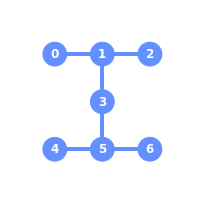

In [51]:
from qiskit.providers.fake_provider.backends import FakeCasablancaV2, FakeWashingtonV2, FakeNairobiV2
import qiskit.visualization as viz
# backend = FakeCasablancaV2()
# backend = FakeWashingtonV2()
backend = FakeNairobiV2()
# # backend.options.enable_truncation = False
viz.plot_gate_map(backend, figsize=(3.5, 3.5))



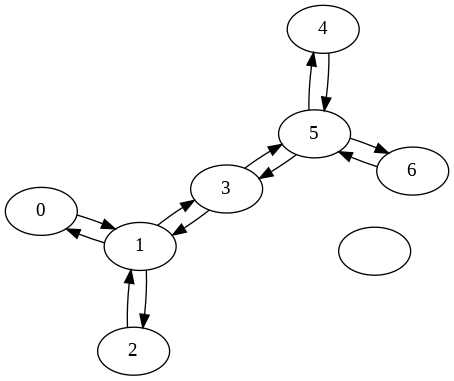

In [52]:
backend.coupling_map.draw()

In [53]:
# Construct the optimal circuit from the VQE Run above
vqe_optimal_circ = vqe.ansatz.assign_parameters(result_vqe.optimal_point)
# Initialize a QuantumInstance with a 'Fake Backend': 
qi = QuantumInstance(backend, seed_simulator=5, seed_transpiler=5)
# Transpile our optimal VQE Circuit with this new backend: 
transpiled_vqe = qi.transpile(vqe_optimal_circ )[0]

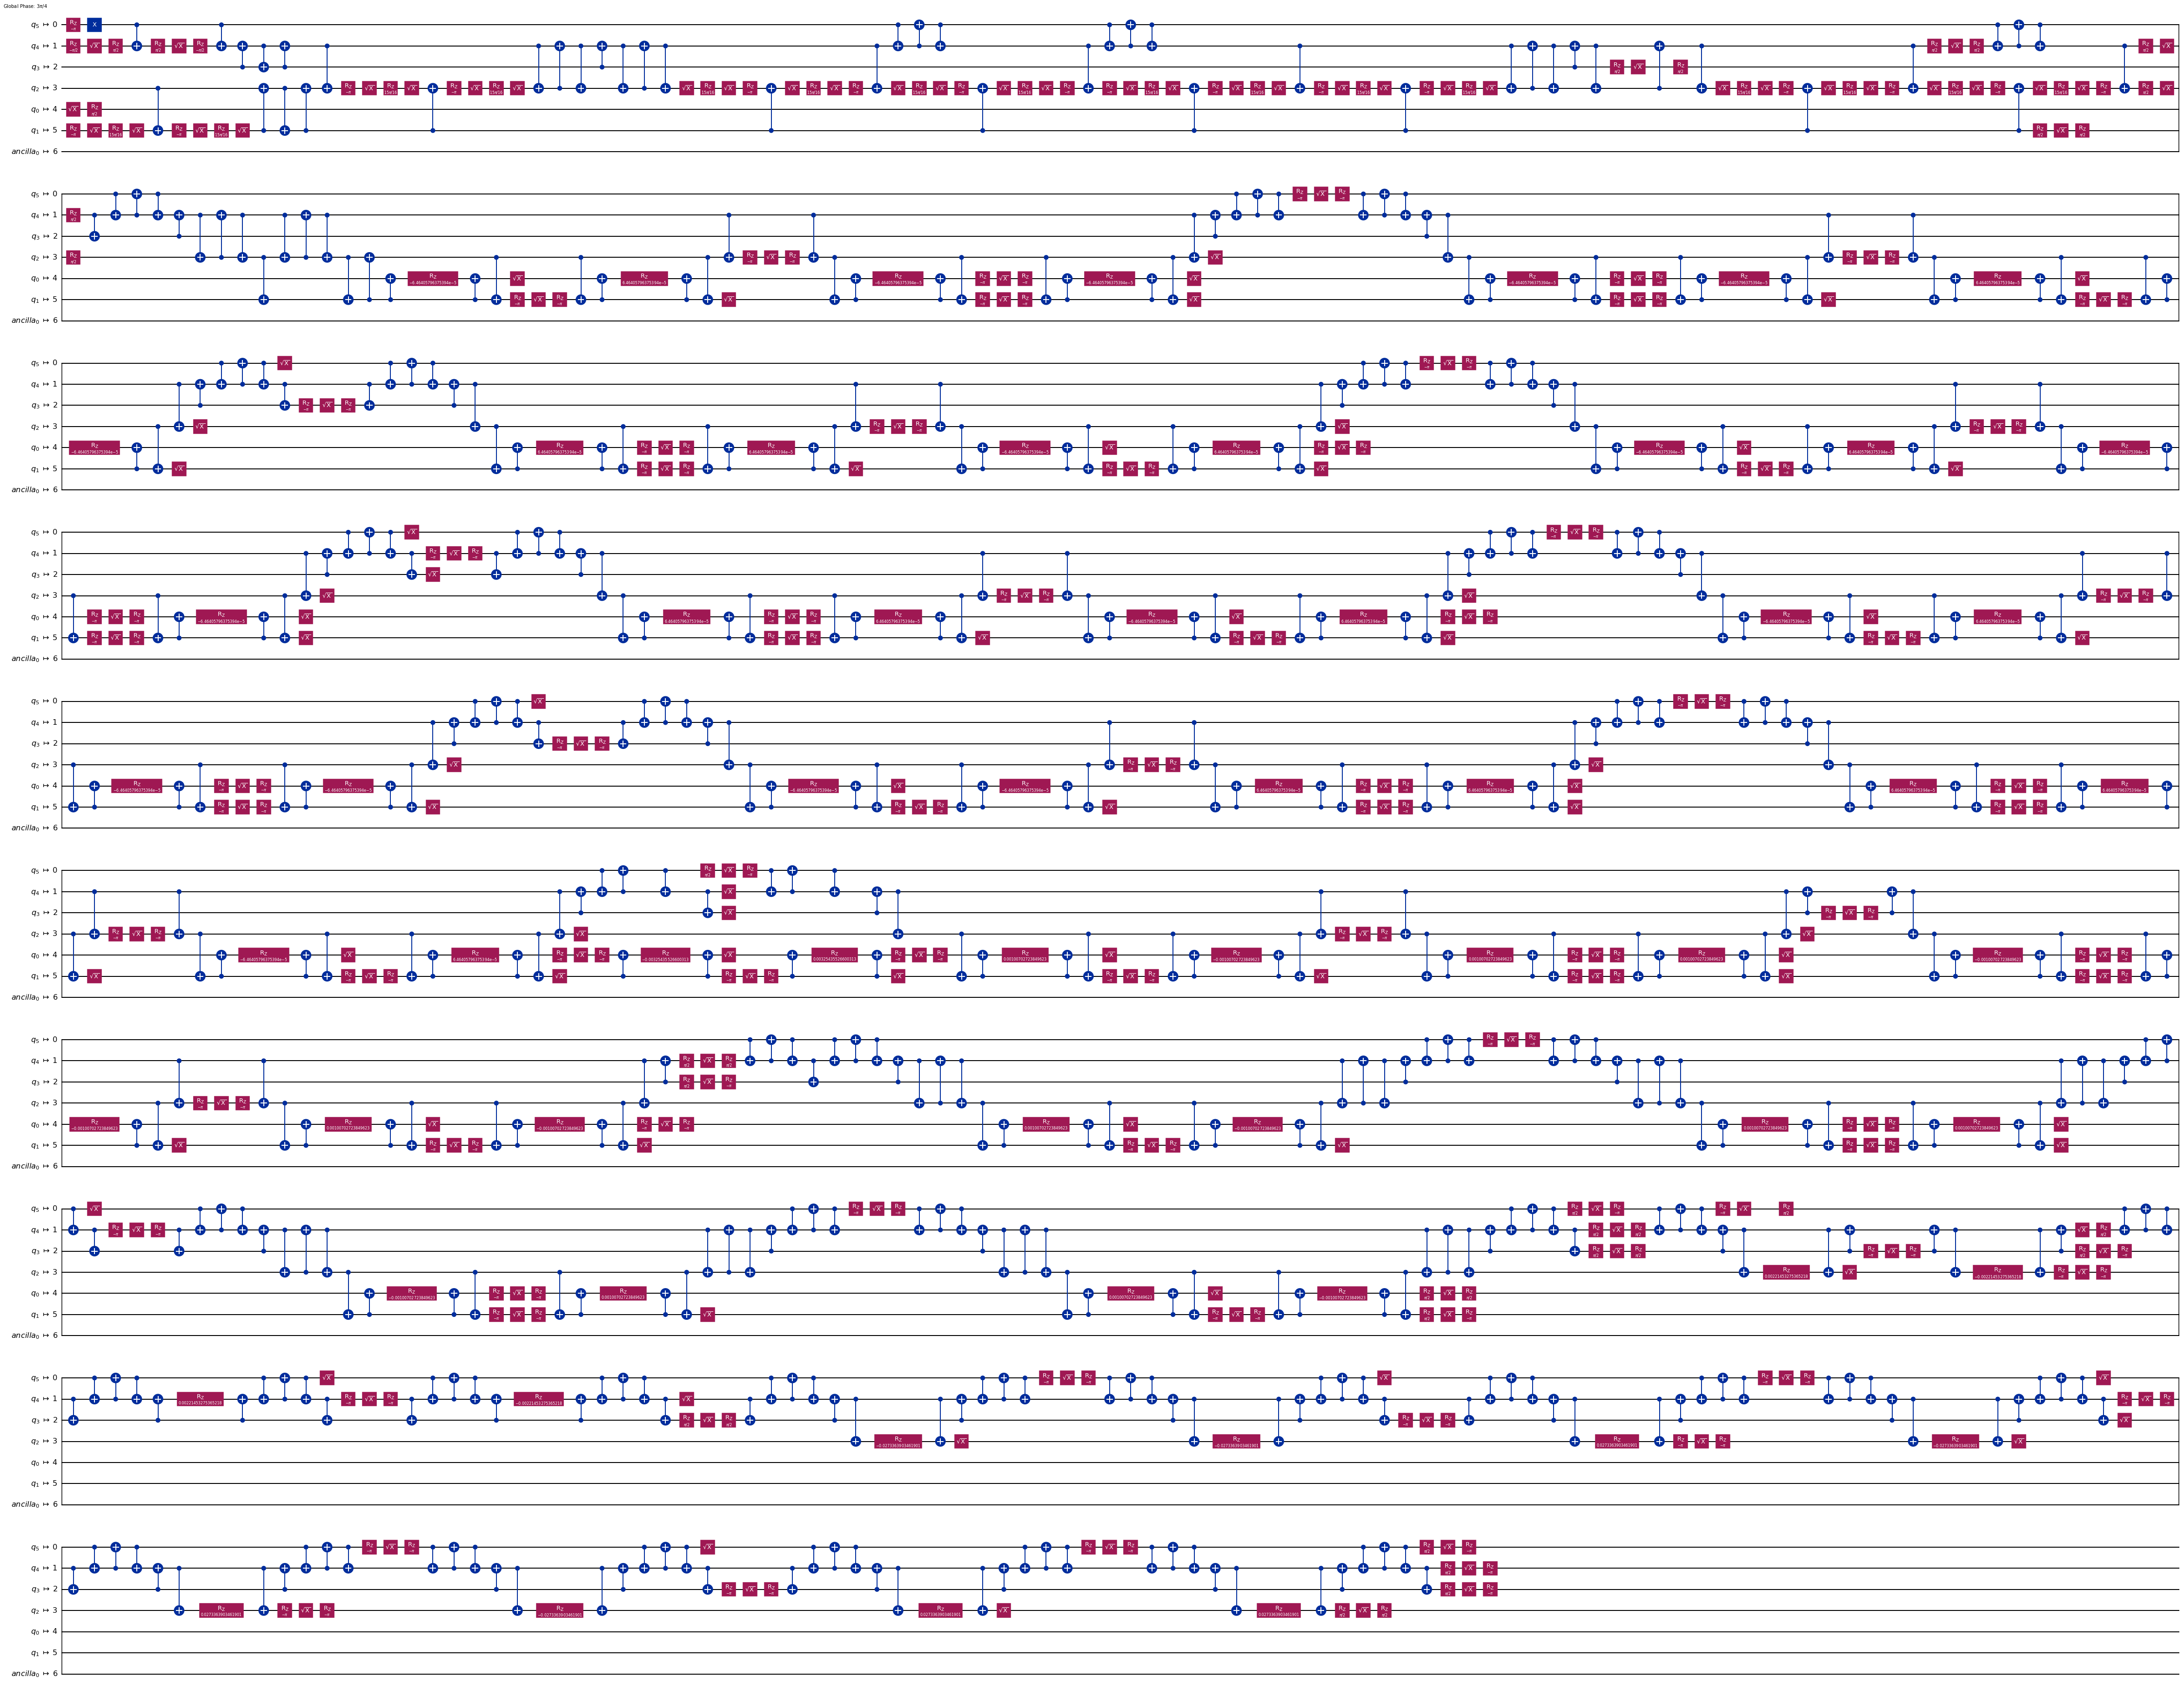

In [54]:
transpiled_vqe.draw('mpl', fold=100, style='iqx', filename='VQE_Circuit_0.pdf')

In [55]:
transpiled_vqe.count_ops() # FakeNairobi

OrderedDict([('cx', 552), ('rz', 291), ('sx', 199), ('x', 1)])